# Installations and setup

In [1]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9\.]{3,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.32.post2" if v == "2.8.0" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.55.4
!pip install --no-deps trl==0.22.2
!pip install --no-deps evaluate rouge_score

In [4]:
from evaluate import load # Import from evaluate instead of datasets
import numpy as np
from tqdm import tqdm
import json
from unsloth import FastLanguageModel
import torch

random_state = 3407

max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 15 trillion tokens model 2x faster!
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # We also uploaded 4bit for 405b!
    "unsloth/Mistral-Nemo-Base-2407-bnb-4bit", # New Mistral 12b 2x faster!
    "unsloth/Mistral-Nemo-Instruct-2407-bnb-4bit",
    "unsloth/mistral-7b-v0.3-bnb-4bit",        # Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

AttributeError: partially initialized module 'torch._dynamo' has no attribute 'decorators' (most likely due to a circular import)

In [5]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 8, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = random_state,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.10.12 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


## Dataset Prep

In [6]:
prompt = """
### Human:
{}

### Assistant
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    outputs      = examples["output"]
    texts = []
    for instruction, output in zip(instructions, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = prompt.format(instruction, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }

from datasets import load_dataset
dataset = load_dataset("azimidokht/recipe-recom", split = "train")
dataset = dataset.map(formatting_prompts_func, batched = True,)

split_dataset = dataset.train_test_split(test_size=0.2, shuffle=True, seed=random_state)

train_dataset = split_dataset["train"]
temp_dataset  = split_dataset["test"]

val_test_split = temp_dataset.train_test_split(test_size=0.5, shuffle=True, seed=random_state)

val_dataset  = val_test_split["train"]
test_dataset = val_test_split["test"]


recipe_recom.parquet:   0%|          | 0.00/214k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5149 [00:00<?, ? examples/s]

Map:   0%|          | 0/5149 [00:00<?, ? examples/s]

# Utilities and functions

In [2]:
prompt = """
### Human:
{}

### Assistant
{}"""
rouge = load("rouge")
bleu = load("bleu")

inferenced_data = {}

def generate_predictions(dataset, model, tokenizer, max_new_tokens=128):
    """Generate model outputs for a HF datasets split of dicts with keys: instruction, output."""
    predictions, references, instructions = [], [], []
    FastLanguageModel.for_inference(model)
    for example in tqdm(dataset):
        instruction = example["instruction"]
        reference   = example["output"]

        inputs = tokenizer(
            [prompt.format(instruction, "")],
            return_tensors="pt"
        ).to("cuda")

        outputs = model.generate(**inputs, max_new_tokens=max_new_tokens, use_cache=True)
        generated_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

        # It Extracts just the assistant section
        # Falls back to full text if the delimiter isn't present
        #If the model output doesn’t include the separator (### Assistant), use the full text as the prediction instead of trying to split it.
        if "### Assistant" in generated_text:
            assistant_response = generated_text.split("### Assistant", 1)[-1].strip()
        else:
            assistant_response = generated_text.strip()

        predictions.append(assistant_response)
        references.append(reference)
        instructions.append(instruction)
    return predictions, references, instructions
    

def evaluate(predictions, references, metrics: list[str]):
    """
    Evaluate the predictions against the references using the specified metrics.
    """
    results = {}
    if "rouge" in metrics:
      results["rouge"] = rouge.compute(predictions=predictions, references=references)
    if "bleu" in metrics:
      results["bleu"] = bleu.compute(predictions=predictions, references=[[ref] for ref in references]) # BLEU expects a list of references
    else:
      raise ValueError("Invalid metric")

    return results

def store(data, path):
  with open(path, "w") as f:
    json.dump(data, f)



NameError: name 'load' is not defined

# Base model evaluation

In [ ]:

print("\nGenerating predictions for the validation dataset...")
val_predictions_base, val_references_base, val_inst_base = generate_predictions(val_dataset, model, tokenizer)
print("Generating predictions for the test dataset...")
test_predictions_base, test_references_base, test_inst_base = generate_predictions(test_dataset, model, tokenizer)



KeyboardInterrupt: 

In [ ]:
inferenced_data["test"] = [val_predictions_base, val_references_base, val_inst_base]
inferenced_data["val"] = [test_predictions_base, test_references_base, test_inst_base]

store(inferenced_data, "./base-inference.json")

In [ ]:
# load if available


val_results = evaluate(val_predictions_base, val_references_base, metrics=["rouge", "bleu"])
print("Validation Rouge results:", val_results["rouge"])
print("Validation BLEU results:", val_results["bleu"])

test_results = evaluate(test_predictions_base, test_references_base, metrics=["rouge", "bleu"])
print("Test Rouge results:", test_results["rouge"])
print("Test BLEU results:", test_results["bleu"])

NameError: name 'evaluate' is not defined

## Hallucination

In [2]:
import json
import re
from pathlib import Path
from typing import Dict, Any, List, Tuple, Optional

import numpy as np
import pandas as pd

# CONFIG - change file names / keys if needed
JSON_PATH = "../results/base-inference-r8.json"   # <- path to your jsondump
CSV_PATH = "../data/pp_recipes.csv"          # <- hummus recipes CSV
OUTPUT_SUMMARY_CSV = "constraint_evaluation_summary_base.csv"

# Columns mapping from your description (adjust if different)
COLS = {
    "title": "title",
    "calories": "calories [cal]",
    "protein": "protein [g]",
    "sodium": "sodium [mg]",
    "duration": "duration",           # may be string/object - ensure numeric if possible
    "serves": "serves",
    "total_fat": "totalFat [g]",
    "carbs": "totalCarbohydrate [g]",
    "fiber": "dietaryFiber [g]",
    "ingredients": "ingredients"
}

# -------------------------
# Helper functions
# -------------------------
def load_inputs(json_path: str) -> Dict[str, Any]:
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data


def load_df(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path, index_col=0, low_memory=True)
    # Normalise title for matching
    df[COLS["title"]] = df[COLS["title"]].astype(str).str.strip()
    # Try converting numeric columns
    for c in ["calories", "protein", "sodium", "duration", "total_fat", "carbs", "fiber"]:
        colname = COLS.get(c)
        if colname in df.columns:
            # remove non-numeric and coerce
            df[colname] = pd.to_numeric(df[colname].astype(str).str.replace(r"[^\d\.\-]", "", regex=True), errors="coerce")
    # Normalize ingredients column to lowercase string for containment checks
    if COLS["ingredients"] in df.columns:
        df[COLS["ingredients"]] = df[COLS["ingredients"]].astype(str).str.lower()
    return df


def extract_title_and_claims(model_output: str) -> Tuple[Optional[str], Dict[str, float], List[str]]:
    """
    Extract a claimed title and numeric claims from model output.
    Returns (title, numeric_claims, list_of_mentioned_ingredients)
    Numeric claims keys: calories, protein, sodium, duration, serves, fiber, total_fat, carbs
    This function uses heuristic regex matching on outputs like:
      "Hummus Delight - 350 calories, 15g protein, ready in 20 minutes."
      "Title - Takes 12 minutes, 300.0 calories"
    """
    claims = {}
    ing_list = []

    if not isinstance(model_output, str):
        return None, claims, ing_list

    # Attempt to parse "Title - ..." or "Title: ..." or "Title — ..."
    m = re.match(r'^\s*([^\-\–\—\:]+?)\s*(?:[-\–\—\:])\s*(.*)$', model_output.strip())
    if m:
        title = m.group(1).strip()
        rest = m.group(2)
    else:
        # fallback: first token phrase before comma
        parts = model_output.split(",")
        title = parts[0].strip()
        rest = ", ".join(parts[1:]) if len(parts) > 1 else ""

    # numeric captures
    # calories: "350 calories" or "350.0 calories"
    mcal = re.search(r'([0-9]+(?:\.[0-9]+)?)\s*(?:calories|cal|kcal)\b', model_output, flags=re.I)
    if mcal:
        claims["calories"] = float(mcal.group(1))
    # protein: "15g protein"
    mprot = re.search(r'([0-9]+(?:\.[0-9]+)?)\s*g\s*(?:protein)\b', model_output, flags=re.I)
    if mprot:
        claims["protein"] = float(mprot.group(1))
    # sodium: "180mg sodium"
    msod = re.search(r'([0-9]+(?:\.[0-9]+)?)\s*mg\s*(?:sodium)\b', model_output, flags=re.I)
    if msod:
        claims["sodium"] = float(msod.group(1))
    # duration: "ready in 20 minutes", "Takes 12 minutes"
    mtime = re.search(r'(\d+)\s*(?:minutes|min|mins)\b', model_output, flags=re.I)
    if mtime:
        claims["duration"] = float(mtime.group(1))
    # serves: "serves 4"
    mserves = re.search(r'serves\s*(\d+)', model_output, flags=re.I)
    if mserves:
        claims["serves"] = int(mserves.group(1))
    # fiber: "5g fiber"
    mfib = re.search(r'([0-9]+(?:\.[0-9]+)?)\s*g\s*(?:dietary fiber|fiber)\b', model_output, flags=re.I)
    if mfib:
        claims["fiber"] = float(mfib.group(1))
    # total_fat: "9g fat"
    mfat = re.search(r'([0-9]+(?:\.[0-9]+)?)\s*g\s*(?:fat)\b', model_output, flags=re.I)
    if mfat:
        claims["total_fat"] = float(mfat.group(1))
    # carbs: "30g carbs"
    mcarb = re.search(r'([0-9]+(?:\.[0-9]+)?)\s*g\s*(?:carb|carbs|carbohydrate|carbohydrates)\b', model_output, flags=re.I)
    if mcarb:
        claims["carbs"] = float(mcarb.group(1))

    # Extract simple ingredients mentioned like "Features chickpeas and tahini"
    # Look for "Features X and Y" or "using X and Y" patterns
    ming = re.search(r'(?:features|using|uses|with)\s+([a-zA-Z0-9\s\-\']+?)\s*(?:,|\band\b|\.)', model_output, flags=re.I)
    if ming:
        # split on 'and' or commas
        text = ming.group(1)
        candidates = re.split(r'\band\b|,', text, flags=re.I)
        ing_list = [c.strip().lower() for c in candidates if c.strip()]

    # fallback: look for "using X and Y." explicit pattern
    m2 = re.search(r'using\s+([^\.,]+?)\.', model_output, flags=re.I)
    if m2:
        parts = re.split(r'\band\b|,', m2.group(1))
        ing_list = [p.strip().lower() for p in parts if p.strip()]

    return title if title else None, claims, ing_list


def parse_instruction_to_constraints(instruction: str) -> Dict[str, Any]:
    """
    Given an instruction string (as generated in variants), return a constraints dict.
    Supports the variant instruction formats you provided.
    """
    instr = instruction.lower()
    constraints = {}

    # calories: "under 400 calories" or "around 400 calories" or "under 400"
    m = re.search(r'under\s+(\d+)', instr)
    if m:
        constraints["calories_max"] = float(m.group(1))
    m2 = re.search(r'around\s+(\d+)', instr)
    if m2:
        val = float(m2.group(1))
        # allow +/- 50 calories tolerance for "around"
        constraints["calories_min"] = max(0.0, val - 50)
        constraints["calories_max"] = val + 50

    # time-based: "less than X minutes"
    mtime = re.search(r'less than\s+(\d+)\s*minutes', instr)
    if mtime:
        constraints["duration_max"] = float(mtime.group(1))

    # protein: "at least Xg protein" or "high-protein at least X"
    mprot = re.search(r'at least\s+(\d+)\s*g\s*protein', instr)
    if mprot:
        constraints["protein_min"] = float(mprot.group(1))
    else:
        # "high-protein recipe with at least 12g protein." or "high-protein with at least 10"
        mprot2 = re.search(r'(\d+)\s*g\s*protein', instr)
        if mprot2 and 'high-protein' in instr:
            constraints["protein_min"] = float(mprot2.group(1))

    # sodium: "under Xmg sodium"
    msod = re.search(r'under\s+(\d+)\s*mg\s*sodium', instr)
    if msod:
        constraints["sodium_max"] = float(msod.group(1))

    # ingredient-based: "using X and Y"
    ming = re.search(r'suggest a recipe using\s+([a-z0-9\s\-\']+?)\s+and\s+([a-z0-9\s\-\']+)', instr)
    if ming:
        constraints["ingredients_include"] = [ming.group(1).strip(), ming.group(2).strip()]

    # fiber: "at least Xg fiber" or "high-fiber at least"
    mf = re.search(r'at least\s+(\d+)\s*g\s*fiber', instr)
    if mf:
        constraints["fiber_min"] = float(mf.group(1))
    mff = re.search(r'high-fiber.*?(\d+)', instr)
    if mff and "fiber" in instr:
        constraints["fiber_min"] = float(mff.group(1))

    # balanced meal: this is generic -> require calories, protein, total_fat present and between some moderate bounds
    if "balanced meal" in instr:
        constraints["balanced"] = True

    # time variant in your code: instruction uses "less than {duration + 10} minutes"
    mquick = re.search(r'less than\s+(\d+)\s*minutes', instr)
    if mquick:
        constraints["duration_max"] = float(mquick.group(1))

    return constraints


def recipe_satisfies_constraints(recipe_row: pd.Series, constraints: Dict[str, Any]) -> bool:
    """
    Returns True if the pandas series (one recipe) satisfies all constraints.
    """
    try:
        # calories
        if "calories_max" in constraints:
            if pd.isna(recipe_row[COLS["calories"]]):
                return False
            if recipe_row[COLS["calories"]] > constraints["calories_max"]:
                return False
        if "calories_min" in constraints:
            if pd.isna(recipe_row[COLS["calories"]]):
                return False
            if recipe_row[COLS["calories"]] < constraints["calories_min"]:
                return False
        # duration
        if "duration_max" in constraints:
            if COLS["duration"] not in recipe_row or pd.isna(recipe_row[COLS["duration"]]):
                return False
            if float(recipe_row[COLS["duration"]]) > constraints["duration_max"]:
                return False
        # protein
        if "protein_min" in constraints:
            if pd.isna(recipe_row[COLS["protein"]]):
                return False
            if recipe_row[COLS["protein"]] < constraints["protein_min"]:
                return False
        # sodium
        if "sodium_max" in constraints:
            if pd.isna(recipe_row[COLS["sodium"]]):
                return False
            if recipe_row[COLS["sodium"]] > constraints["sodium_max"]:
                return False
        # ingredients include
        if "ingredients_include" in constraints:
            ing_field = recipe_row.get(COLS["ingredients"], "")
            if not isinstance(ing_field, str):
                return False
            ing_field_low = ing_field.lower()
            for ing in constraints["ingredients_include"]:
                if ing.lower() not in ing_field_low:
                    return False
        # fiber
        if "fiber_min" in constraints:
            if pd.isna(recipe_row[COLS["fiber"]]):
                return False
            if recipe_row[COLS["fiber"]] < constraints["fiber_min"]:
                return False
        # balanced: require numeric calories/protein/total_fat exists; simple heuristics
        if constraints.get("balanced"):
            if any(pd.isna(recipe_row.get(COLS.get(k), None)) for k in ["calories", "protein", "total_fat"]):
                return False
            # require moderate calories <= 700 and protein >= 10
            if recipe_row[COLS["calories"]] > 700:
                return False
            if recipe_row[COLS["protein"]] < 8:
                return False
        return True
    except Exception as e:
        # if any unexpected error, return False
        return False


def find_any_matching_recipe(df: pd.DataFrame, constraints: Dict[str, Any]) -> Optional[pd.Series]:
    """
    Returns first matching recipe row (as Series) that satisfies constraints, or None.
    """
    # quick vectorized filter approach
    mask = pd.Series(True, index=df.index)

    if "calories_max" in constraints and COLS["calories"] in df.columns:
        mask &= df[COLS["calories"]].fillna(np.inf) <= constraints["calories_max"]
    if "calories_min" in constraints and COLS["calories"] in df.columns:
        mask &= df[COLS["calories"]].fillna(-np.inf) >= constraints["calories_min"]
    if "duration_max" in constraints and COLS["duration"] in df.columns:
        mask &= df[COLS["duration"]].fillna(np.inf) <= constraints["duration_max"]
    if "protein_min" in constraints and COLS["protein"] in df.columns:
        mask &= df[COLS["protein"]].fillna(-np.inf) >= constraints["protein_min"]
    if "sodium_max" in constraints and COLS["sodium"] in df.columns:
        mask &= df[COLS["sodium"]].fillna(np.inf) <= constraints["sodium_max"]
    if "fiber_min" in constraints and COLS["fiber"] in df.columns:
        mask &= df[COLS["fiber"]].fillna(-np.inf) >= constraints["fiber_min"]
    if "ingredients_include" in constraints and COLS["ingredients"] in df.columns:
        for ing in constraints["ingredients_include"]:
            mask &= df[COLS["ingredients"]].str.contains(ing.lower(), na=False)

    # balanced: apply heuristic
    if constraints.get("balanced"):
        mask &= df[COLS["calories"]].fillna(np.inf) <= 700
        mask &= df[COLS["protein"]].fillna(-np.inf) >= 8
        mask &= df[COLS["total_fat"]].fillna(-np.inf) > 0

    filtered = df[mask]
    if len(filtered) == 0:
        return None
    return filtered.iloc[0]


# -------------------------
# Main evaluation
# -------------------------
def evaluate(inferenced_data: Dict[str, Any], df: pd.DataFrame, split_key: str = "test"):
    """
    Expects inferenced_data[split_key] to be [predictions_list, references_list, instructions_list]
    Each element in predictions_list corresponds to a model output. In your variant setup, you might
    have predictions as lists of variants per recipe; we attempt to handle either flat lists or nested.
    """
    preds, refs, insts = inferenced_data[split_key]

    # Normalize lists: if preds is a dict or nested list-of-lists, flatten into per-variant instruction objects.
    # We'll assume 'insts' is parallel: each entry may contain 'variants' list (per your earlier generation),
    # or insts may already be the list of generated 'instruction' strings.
    # We'll construct a list of dicts: { "instruction": ..., "output": ... }
    records = []

    # Case A: you saved a structure of variants per example (list of dicts with "instruction" and "output")
    # We'll detect types and normalize.
    if isinstance(preds, list) and len(preds) > 0 and isinstance(preds[0], dict) and 'output' in preds[0]:
        # already normalized predictions as dicts
        normalized = preds
    else:
        # Attempt to pair insts and preds element-wise
        normalized = []
        # If preds entries are lists of outputs per example and insts are lists of variants (list-of-dicts)
        if isinstance(preds, list) and len(preds) == len(insts):
            for p, i in zip(preds, insts):
                # If i is list of variant dicts
                if isinstance(i, list):
                    # each variant has instruction + output but model output might be in p list in same order
                    # Best effort: if p is list with same length, pair them; otherwise assume p is single str
                    if isinstance(p, list) and len(p) == len(i):
                        for out, var in zip(p, i):
                            normalized.append({"instruction": var.get("instruction") if isinstance(var, dict) else str(var),
                                               "output": out})
                    else:
                        # pair each variant instruction with same p (string)
                        for var in i:
                            normalized.append({"instruction": var.get("instruction") if isinstance(var, dict) else str(var),
                                               "output": p if isinstance(p, str) else str(p)})
                else:
                    # i is a single instruction string
                    normalized.append({"instruction": i, "output": p})
        else:
            # fallback: if insts is list of variant dicts
            if isinstance(insts, list):
                for entry in insts:
                    if isinstance(entry, dict) and 'instruction' in entry and 'output' in entry:
                        normalized.append({"instruction": entry['instruction'], "output": entry['output']})
                    elif isinstance(entry, dict) and 'instruction' in entry:
                        normalized.append({"instruction": entry['instruction'], "output": ""})
                    else:
                        # can't interpret; make best-effort
                        normalized.append({"instruction": str(entry), "output": ""})
            else:
                raise ValueError("Unable to normalize predictions/instructions structure. Inspect your inferenced_data format.")

    # Now evaluate each normalized pair
    for item in normalized:
        instruction = item.get("instruction", "")
        output = item.get("output", "")
        title, claims, mentioned_ings = extract_title_and_claims(output)
        constraints = parse_instruction_to_constraints(instruction)

        title_present = False
        recipe_row = None
        if title:
            # try exact or case-insensitive match in df titles
            matches = df[df[COLS["title"]].str.lower() == title.lower()]
            if len(matches) == 0:
                # try substring match
                matches = df[df[COLS["title"]].str.lower().str.contains(re.escape(title.lower()), na=False)]
            if len(matches) > 0:
                title_present = True
                recipe_row = matches.iloc[0]

        # Check if the title's referenced recipe (if present) satisfies constraints
        satisfied_by_returned = False
        if title_present and recipe_row is not None and constraints:
            satisfied_by_returned = recipe_satisfies_constraints(recipe_row, constraints)
        elif title_present and (not constraints):
            # if no constraints parsed, consider it satisfied_by_returned = True (no constraint)
            satisfied_by_returned = True

        # Check whether any recipe in dataset satisfies constraints (for recall/TP/FN)
        any_matching = True if not constraints else (find_any_matching_recipe(df, constraints) is not None)

        # Hallucination: title not found in dataset
        hallucinated = not title_present

        records.append({
            "instruction": instruction,
            "model_output": output,
            "parsed_title": title,
            "title_in_dataset": title_present,
            "satisfied_by_returned": satisfied_by_returned,
            "dataset_has_any_matching": any_matching,
            "hallucinated": hallucinated,
            "constraints": constraints,
            "claims": claims,
            "mentioned_ingredients": mentioned_ings
        })

    # Compute metrics:
    TP = 0  # dataset has a matching recipe AND model returned an example that satisfied constraints
    FP = 0  # model returned a recipe that DOES NOT satisfy constraints OR hallucination where dataset had none
    FN = 0  # dataset has a matching recipe but model either returned non-matching recipe or hallucinated/no answer

    for r in records:
        if r["dataset_has_any_matching"]:
            # ground truth: there exists an example satisfying constraints
            if r["title_in_dataset"] and r["satisfied_by_returned"]:
                TP += 1
            else:
                FN += 1
        else:
            # dataset has no matching recipe
            if r["title_in_dataset"]:
                # model returned a recipe (but dataset actually doesn't have matching recipe!) -> FP
                FP += 1
            else:
                # model did not return any recipe (and none exists): true negative (not used in precision/recall)
                pass

    # Another kind of FP: returned a recipe but it didn't satisfy constraints (even though dataset has matching recipe).
    # The above counts that as FN (because dataset_has_any_matching true and model didn't return matching) — acceptable.
    # Also count hallucinated returns (title not present) as FP when dataset_has_any_matching is False or True
    # For clarity compute hallucination rate:
    total_outputs = len(records)
    halluc_count = sum(1 for r in records if r["hallucinated"])
    halluc_rate = halluc_count / total_outputs if total_outputs > 0 else 0.0

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    summary_df = pd.DataFrame(records)
    summary_df.to_csv(OUTPUT_SUMMARY_CSV, index=False)

    metrics = {
        "total_examples": total_outputs,
        "TP": TP,
        "FP": FP,
        "FN": FN,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "hallucination_count": halluc_count,
        "hallucination_rate": halluc_rate,
        "summary_csv": OUTPUT_SUMMARY_CSV
    }

    return summary_df, metrics


# -------------------------
# Entry point
# -------------------------
if __name__ == "__main__":
    # Load files
    print("Loading JSON:", JSON_PATH)
    inferenced = load_inputs(JSON_PATH)
    print("Loading hummus CSV:", CSV_PATH)
    df = load_df(CSV_PATH)

    # Choose split to evaluate - 'test' or 'val' - modify if needed
    split_to_eval = "test"
    if split_to_eval not in inferenced:
        # fallback to 'val' or first key
        if "val" in inferenced:
            split_to_eval = "val"
        else:
            split_to_eval = list(inferenced.keys())[0]

    print(f"Evaluating split: {split_to_eval}")
    summary_df, metrics = evaluate(inferenced, df, split_key=split_to_eval)

    print("\n=== Metrics ===")
    for k, v in metrics.items():
        print(f"{k}: {v}")
    print(f"\nDetailed summary saved to {metrics['summary_csv']}")


Loading JSON: ../results/base-inference-r8.json
Loading hummus CSV: ../data/pp_recipes.csv


/var/folders/1g/st98989x26136dtmmybf9mdc0000gn/T/ipykernel_22720/1015138889.py:38: DtypeWarning: Columns (35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path, index_col=0, low_memory=True)


Evaluating split: test

=== Metrics ===
total_examples: 515
TP: 14
FP: 0
FN: 501
precision: 1.0
recall: 0.027184466019417475
f1: 0.05293005671077505
hallucination_count: 488
hallucination_rate: 0.9475728155339805
summary_csv: constraint_evaluation_summary_base.csv

Detailed summary saved to constraint_evaluation_summary_base.csv


# Fine-tined model evaluation

In [8]:
# Load the model and tokenizer from the Hugging Face Hub
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "azimidokht/recipe-recom-fine-tuned",  # your HF repo
    max_seq_length = 2048,  # or the same you used during training
    dtype = None,           # or "float16"/"bfloat16" depending on your GPU
    load_in_4bit = True,    # set to True if you trained/quantized with 4-bit
)

==((====))==  Unsloth 2025.10.12: Fast Llama patching. Transformers: 4.55.4.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


adapter_model.safetensors:   0%|          | 0.00/83.9M [00:00<?, ?B/s]

## inference

In [ ]:
inferenced_data_tuned = {}

print("\nGenerating predictions for the validation dataset...")
val_predictions_tuned, val_references_tuned, val_inst_tuned = generate_predictions(val_dataset, model, tokenizer)
print("Generating predictions for the test dataset...")
test_predictions_tuned, test_references_tuned, test_inst_tuned = generate_predictions(test_dataset, model, tokenizer)




Generating predictions for the validation dataset...


100%|██████████| 515/515 [18:59<00:00,  2.21s/it]


Generating predictions for the test dataset...


100%|██████████| 515/515 [18:49<00:00,  2.19s/it]


Validation Rouge results: {'rouge1': np.float64(0.40453685922545124), 'rouge2': np.float64(0.14331750751282368), 'rougeL': np.float64(0.3867874845240147), 'rougeLsum': np.float64(0.38656809820506405)}
Validation BLEU results: {'bleu': 0.18616916303170597, 'precisions': [0.578895096213532, 0.33156498673740054, 0.12156583629893239, 0.060829493087557605], 'brevity_penalty': 0.9591448031459188, 'length_ratio': 0.9599570968895245, 'translation_length': 8055, 'reference_length': 8391}
Test Rouge results: {'rouge1': np.float64(0.3961609293564492), 'rouge2': np.float64(0.1340261275115724), 'rougeL': np.float64(0.3781028237338431), 'rougeLsum': np.float64(0.37816379311891846)}
Test BLEU results: {'bleu': 0.1753465742384433, 'precisions': [0.5765054294175715, 0.32468045855843986, 0.11082838563754595, 0.05320933069065406], 'brevity_penalty': 0.9619947380591407, 'length_ratio': 0.9626989783796627, 'translation_length': 8104, 'reference_length': 8418}


In [ ]:
inferenced_data_tuned["test"] = [val_predictions_tuned, val_references_tuned, val_inst_tuned]
inferenced_data_tuned["val"] = [test_predictions_tuned, test_references_tuned, test_inst_tuned]

store(inferenced_data_tuned, "./fine-tuned-inference-r8.json")

val_results_tuned = evaluate(val_predictions_tuned, val_references_tuned, metrics=["rouge", "bleu"])
print("Validation Rouge results:", val_results_tuned["rouge"])
print("Validation BLEU results:", val_results_tuned["bleu"])

test_results_tuned = evaluate(test_predictions_tuned, test_references_tuned, metrics=["rouge", "bleu"])
print("Test Rouge results:", test_results_tuned["rouge"])
print("Test BLEU results:", test_results_tuned["bleu"])

In [2]:
import json
import re
from pathlib import Path
from typing import Dict, Any, List, Tuple, Optional

import numpy as np
import pandas as pd

# CONFIG - change file names / keys if needed
JSON_PATH = "../results/fine-tuned-inference-r8.json"   # <- path to your jsondump
CSV_PATH = "../data/pp_recipes.csv"          # <- hummus recipes CSV
OUTPUT_SUMMARY_CSV = "constraint_evaluation_summary.csv"

# Columns mapping from your description (adjust if different)
COLS = {
    "title": "title",
    "calories": "calories [cal]",
    "protein": "protein [g]",
    "sodium": "sodium [mg]",
    "duration": "duration",           # may be string/object - ensure numeric if possible
    "serves": "serves",
    "total_fat": "totalFat [g]",
    "carbs": "totalCarbohydrate [g]",
    "fiber": "dietaryFiber [g]",
    "ingredients": "ingredients"
}

# -------------------------
# Helper functions
# -------------------------
def load_inputs(json_path: str) -> Dict[str, Any]:
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data


def load_df(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path, index_col=0, low_memory=True)
    # Normalise title for matching
    df[COLS["title"]] = df[COLS["title"]].astype(str).str.strip()
    # Try converting numeric columns
    for c in ["calories", "protein", "sodium", "duration", "total_fat", "carbs", "fiber"]:
        colname = COLS.get(c)
        if colname in df.columns:
            # remove non-numeric and coerce
            df[colname] = pd.to_numeric(df[colname].astype(str).str.replace(r"[^\d\.\-]", "", regex=True), errors="coerce")
    # Normalize ingredients column to lowercase string for containment checks
    if COLS["ingredients"] in df.columns:
        df[COLS["ingredients"]] = df[COLS["ingredients"]].astype(str).str.lower()
    return df


def extract_title_and_claims(model_output: str) -> Tuple[Optional[str], Dict[str, float], List[str]]:
    """
    Extract a claimed title and numeric claims from model output.
    Returns (title, numeric_claims, list_of_mentioned_ingredients)
    Numeric claims keys: calories, protein, sodium, duration, serves, fiber, total_fat, carbs
    This function uses heuristic regex matching on outputs like:
      "Hummus Delight - 350 calories, 15g protein, ready in 20 minutes."
      "Title - Takes 12 minutes, 300.0 calories"
    """
    claims = {}
    ing_list = []

    if not isinstance(model_output, str):
        return None, claims, ing_list

    # Attempt to parse "Title - ..." or "Title: ..." or "Title — ..."
    m = re.match(r'^\s*([^\-\–\—\:]+?)\s*(?:[-\–\—\:])\s*(.*)$', model_output.strip())
    if m:
        title = m.group(1).strip()
        rest = m.group(2)
    else:
        # fallback: first token phrase before comma
        parts = model_output.split(",")
        title = parts[0].strip()
        rest = ", ".join(parts[1:]) if len(parts) > 1 else ""

    # numeric captures
    # calories: "350 calories" or "350.0 calories"
    mcal = re.search(r'([0-9]+(?:\.[0-9]+)?)\s*(?:calories|cal|kcal)\b', model_output, flags=re.I)
    if mcal:
        claims["calories"] = float(mcal.group(1))
    # protein: "15g protein"
    mprot = re.search(r'([0-9]+(?:\.[0-9]+)?)\s*g\s*(?:protein)\b', model_output, flags=re.I)
    if mprot:
        claims["protein"] = float(mprot.group(1))
    # sodium: "180mg sodium"
    msod = re.search(r'([0-9]+(?:\.[0-9]+)?)\s*mg\s*(?:sodium)\b', model_output, flags=re.I)
    if msod:
        claims["sodium"] = float(msod.group(1))
    # duration: "ready in 20 minutes", "Takes 12 minutes"
    mtime = re.search(r'(\d+)\s*(?:minutes|min|mins)\b', model_output, flags=re.I)
    if mtime:
        claims["duration"] = float(mtime.group(1))
    # serves: "serves 4"
    mserves = re.search(r'serves\s*(\d+)', model_output, flags=re.I)
    if mserves:
        claims["serves"] = int(mserves.group(1))
    # fiber: "5g fiber"
    mfib = re.search(r'([0-9]+(?:\.[0-9]+)?)\s*g\s*(?:dietary fiber|fiber)\b', model_output, flags=re.I)
    if mfib:
        claims["fiber"] = float(mfib.group(1))
    # total_fat: "9g fat"
    mfat = re.search(r'([0-9]+(?:\.[0-9]+)?)\s*g\s*(?:fat)\b', model_output, flags=re.I)
    if mfat:
        claims["total_fat"] = float(mfat.group(1))
    # carbs: "30g carbs"
    mcarb = re.search(r'([0-9]+(?:\.[0-9]+)?)\s*g\s*(?:carb|carbs|carbohydrate|carbohydrates)\b', model_output, flags=re.I)
    if mcarb:
        claims["carbs"] = float(mcarb.group(1))

    # Extract simple ingredients mentioned like "Features chickpeas and tahini"
    # Look for "Features X and Y" or "using X and Y" patterns
    ming = re.search(r'(?:features|using|uses|with)\s+([a-zA-Z0-9\s\-\']+?)\s*(?:,|\band\b|\.)', model_output, flags=re.I)
    if ming:
        # split on 'and' or commas
        text = ming.group(1)
        candidates = re.split(r'\band\b|,', text, flags=re.I)
        ing_list = [c.strip().lower() for c in candidates if c.strip()]

    # fallback: look for "using X and Y." explicit pattern
    m2 = re.search(r'using\s+([^\.,]+?)\.', model_output, flags=re.I)
    if m2:
        parts = re.split(r'\band\b|,', m2.group(1))
        ing_list = [p.strip().lower() for p in parts if p.strip()]

    return title if title else None, claims, ing_list


def parse_instruction_to_constraints(instruction: str) -> Dict[str, Any]:
    """
    Given an instruction string (as generated in variants), return a constraints dict.
    Supports the variant instruction formats you provided.
    """
    instr = instruction.lower()
    constraints = {}

    # calories: "under 400 calories" or "around 400 calories" or "under 400"
    m = re.search(r'under\s+(\d+)', instr)
    if m:
        constraints["calories_max"] = float(m.group(1))
    m2 = re.search(r'around\s+(\d+)', instr)
    if m2:
        val = float(m2.group(1))
        # allow +/- 50 calories tolerance for "around"
        constraints["calories_min"] = max(0.0, val - 50)
        constraints["calories_max"] = val + 50

    # time-based: "less than X minutes"
    mtime = re.search(r'less than\s+(\d+)\s*minutes', instr)
    if mtime:
        constraints["duration_max"] = float(mtime.group(1))

    # protein: "at least Xg protein" or "high-protein at least X"
    mprot = re.search(r'at least\s+(\d+)\s*g\s*protein', instr)
    if mprot:
        constraints["protein_min"] = float(mprot.group(1))
    else:
        # "high-protein recipe with at least 12g protein." or "high-protein with at least 10"
        mprot2 = re.search(r'(\d+)\s*g\s*protein', instr)
        if mprot2 and 'high-protein' in instr:
            constraints["protein_min"] = float(mprot2.group(1))

    # sodium: "under Xmg sodium"
    msod = re.search(r'under\s+(\d+)\s*mg\s*sodium', instr)
    if msod:
        constraints["sodium_max"] = float(msod.group(1))

    # ingredient-based: "using X and Y"
    ming = re.search(r'suggest a recipe using\s+([a-z0-9\s\-\']+?)\s+and\s+([a-z0-9\s\-\']+)', instr)
    if ming:
        constraints["ingredients_include"] = [ming.group(1).strip(), ming.group(2).strip()]

    # fiber: "at least Xg fiber" or "high-fiber at least"
    mf = re.search(r'at least\s+(\d+)\s*g\s*fiber', instr)
    if mf:
        constraints["fiber_min"] = float(mf.group(1))
    mff = re.search(r'high-fiber.*?(\d+)', instr)
    if mff and "fiber" in instr:
        constraints["fiber_min"] = float(mff.group(1))

    # balanced meal: this is generic -> require calories, protein, total_fat present and between some moderate bounds
    if "balanced meal" in instr:
        constraints["balanced"] = True

    # time variant in your code: instruction uses "less than {duration + 10} minutes"
    mquick = re.search(r'less than\s+(\d+)\s*minutes', instr)
    if mquick:
        constraints["duration_max"] = float(mquick.group(1))

    return constraints


def recipe_satisfies_constraints(recipe_row: pd.Series, constraints: Dict[str, Any]) -> bool:
    """
    Returns True if the pandas series (one recipe) satisfies all constraints.
    """
    try:
        # calories
        if "calories_max" in constraints:
            if pd.isna(recipe_row[COLS["calories"]]):
                return False
            if recipe_row[COLS["calories"]] > constraints["calories_max"]:
                return False
        if "calories_min" in constraints:
            if pd.isna(recipe_row[COLS["calories"]]):
                return False
            if recipe_row[COLS["calories"]] < constraints["calories_min"]:
                return False
        # duration
        if "duration_max" in constraints:
            if COLS["duration"] not in recipe_row or pd.isna(recipe_row[COLS["duration"]]):
                return False
            if float(recipe_row[COLS["duration"]]) > constraints["duration_max"]:
                return False
        # protein
        if "protein_min" in constraints:
            if pd.isna(recipe_row[COLS["protein"]]):
                return False
            if recipe_row[COLS["protein"]] < constraints["protein_min"]:
                return False
        # sodium
        if "sodium_max" in constraints:
            if pd.isna(recipe_row[COLS["sodium"]]):
                return False
            if recipe_row[COLS["sodium"]] > constraints["sodium_max"]:
                return False
        # ingredients include
        if "ingredients_include" in constraints:
            ing_field = recipe_row.get(COLS["ingredients"], "")
            if not isinstance(ing_field, str):
                return False
            ing_field_low = ing_field.lower()
            for ing in constraints["ingredients_include"]:
                if ing.lower() not in ing_field_low:
                    return False
        # fiber
        if "fiber_min" in constraints:
            if pd.isna(recipe_row[COLS["fiber"]]):
                return False
            if recipe_row[COLS["fiber"]] < constraints["fiber_min"]:
                return False
        # balanced: require numeric calories/protein/total_fat exists; simple heuristics
        if constraints.get("balanced"):
            if any(pd.isna(recipe_row.get(COLS.get(k), None)) for k in ["calories", "protein", "total_fat"]):
                return False
            # require moderate calories <= 700 and protein >= 10
            if recipe_row[COLS["calories"]] > 700:
                return False
            if recipe_row[COLS["protein"]] < 8:
                return False
        return True
    except Exception as e:
        # if any unexpected error, return False
        return False


def find_any_matching_recipe(df: pd.DataFrame, constraints: Dict[str, Any]) -> Optional[pd.Series]:
    """
    Returns first matching recipe row (as Series) that satisfies constraints, or None.
    """
    # quick vectorized filter approach
    mask = pd.Series(True, index=df.index)

    if "calories_max" in constraints and COLS["calories"] in df.columns:
        mask &= df[COLS["calories"]].fillna(np.inf) <= constraints["calories_max"]
    if "calories_min" in constraints and COLS["calories"] in df.columns:
        mask &= df[COLS["calories"]].fillna(-np.inf) >= constraints["calories_min"]
    if "duration_max" in constraints and COLS["duration"] in df.columns:
        mask &= df[COLS["duration"]].fillna(np.inf) <= constraints["duration_max"]
    if "protein_min" in constraints and COLS["protein"] in df.columns:
        mask &= df[COLS["protein"]].fillna(-np.inf) >= constraints["protein_min"]
    if "sodium_max" in constraints and COLS["sodium"] in df.columns:
        mask &= df[COLS["sodium"]].fillna(np.inf) <= constraints["sodium_max"]
    if "fiber_min" in constraints and COLS["fiber"] in df.columns:
        mask &= df[COLS["fiber"]].fillna(-np.inf) >= constraints["fiber_min"]
    if "ingredients_include" in constraints and COLS["ingredients"] in df.columns:
        for ing in constraints["ingredients_include"]:
            mask &= df[COLS["ingredients"]].str.contains(ing.lower(), na=False)

    # balanced: apply heuristic
    if constraints.get("balanced"):
        mask &= df[COLS["calories"]].fillna(np.inf) <= 700
        mask &= df[COLS["protein"]].fillna(-np.inf) >= 8
        mask &= df[COLS["total_fat"]].fillna(-np.inf) > 0

    filtered = df[mask]
    if len(filtered) == 0:
        return None
    return filtered.iloc[0]


# -------------------------
# Main evaluation
# -------------------------
def evaluate(inferenced_data: Dict[str, Any], df: pd.DataFrame, split_key: str = "test"):
    """
    Expects inferenced_data[split_key] to be [predictions_list, references_list, instructions_list]
    Each element in predictions_list corresponds to a model output. In your variant setup, you might
    have predictions as lists of variants per recipe; we attempt to handle either flat lists or nested.
    """
    preds, refs, insts = inferenced_data[split_key]

    # Normalize lists: if preds is a dict or nested list-of-lists, flatten into per-variant instruction objects.
    # We'll assume 'insts' is parallel: each entry may contain 'variants' list (per your earlier generation),
    # or insts may already be the list of generated 'instruction' strings.
    # We'll construct a list of dicts: { "instruction": ..., "output": ... }
    records = []

    # Case A: you saved a structure of variants per example (list of dicts with "instruction" and "output")
    # We'll detect types and normalize.
    if isinstance(preds, list) and len(preds) > 0 and isinstance(preds[0], dict) and 'output' in preds[0]:
        # already normalized predictions as dicts
        normalized = preds
    else:
        # Attempt to pair insts and preds element-wise
        normalized = []
        # If preds entries are lists of outputs per example and insts are lists of variants (list-of-dicts)
        if isinstance(preds, list) and len(preds) == len(insts):
            for p, i in zip(preds, insts):
                # If i is list of variant dicts
                if isinstance(i, list):
                    # each variant has instruction + output but model output might be in p list in same order
                    # Best effort: if p is list with same length, pair them; otherwise assume p is single str
                    if isinstance(p, list) and len(p) == len(i):
                        for out, var in zip(p, i):
                            normalized.append({"instruction": var.get("instruction") if isinstance(var, dict) else str(var),
                                               "output": out})
                    else:
                        # pair each variant instruction with same p (string)
                        for var in i:
                            normalized.append({"instruction": var.get("instruction") if isinstance(var, dict) else str(var),
                                               "output": p if isinstance(p, str) else str(p)})
                else:
                    # i is a single instruction string
                    normalized.append({"instruction": i, "output": p})
        else:
            # fallback: if insts is list of variant dicts
            if isinstance(insts, list):
                for entry in insts:
                    if isinstance(entry, dict) and 'instruction' in entry and 'output' in entry:
                        normalized.append({"instruction": entry['instruction'], "output": entry['output']})
                    elif isinstance(entry, dict) and 'instruction' in entry:
                        normalized.append({"instruction": entry['instruction'], "output": ""})
                    else:
                        # can't interpret; make best-effort
                        normalized.append({"instruction": str(entry), "output": ""})
            else:
                raise ValueError("Unable to normalize predictions/instructions structure. Inspect your inferenced_data format.")

    # Now evaluate each normalized pair
    for item in normalized:
        instruction = item.get("instruction", "")
        output = item.get("output", "")
        title, claims, mentioned_ings = extract_title_and_claims(output)
        constraints = parse_instruction_to_constraints(instruction)

        title_present = False
        recipe_row = None
        if title:
            # try exact or case-insensitive match in df titles
            matches = df[df[COLS["title"]].str.lower() == title.lower()]
            if len(matches) == 0:
                # try substring match
                matches = df[df[COLS["title"]].str.lower().str.contains(re.escape(title.lower()), na=False)]
            if len(matches) > 0:
                title_present = True
                recipe_row = matches.iloc[0]

        # Check if the title's referenced recipe (if present) satisfies constraints
        satisfied_by_returned = False
        if title_present and recipe_row is not None and constraints:
            satisfied_by_returned = recipe_satisfies_constraints(recipe_row, constraints)
        elif title_present and (not constraints):
            # if no constraints parsed, consider it satisfied_by_returned = True (no constraint)
            satisfied_by_returned = True

        # Check whether any recipe in dataset satisfies constraints (for recall/TP/FN)
        any_matching = True if not constraints else (find_any_matching_recipe(df, constraints) is not None)

        # Hallucination: title not found in dataset
        hallucinated = not title_present

        records.append({
            "instruction": instruction,
            "model_output": output,
            "parsed_title": title,
            "title_in_dataset": title_present,
            "satisfied_by_returned": satisfied_by_returned,
            "dataset_has_any_matching": any_matching,
            "hallucinated": hallucinated,
            "constraints": constraints,
            "claims": claims,
            "mentioned_ingredients": mentioned_ings
        })

    # Compute metrics:
    TP = 0  # dataset has a matching recipe AND model returned an example that satisfied constraints
    FP = 0  # model returned a recipe that DOES NOT satisfy constraints OR hallucination where dataset had none
    FN = 0  # dataset has a matching recipe but model either returned non-matching recipe or hallucinated/no answer

    for r in records:
        if r["dataset_has_any_matching"]:
            # ground truth: there exists an example satisfying constraints
            if r["title_in_dataset"] and r["satisfied_by_returned"]:
                TP += 1
            else:
                FN += 1
        else:
            # dataset has no matching recipe
            if r["title_in_dataset"]:
                # model returned a recipe (but dataset actually doesn't have matching recipe!) -> FP
                FP += 1
            else:
                # model did not return any recipe (and none exists): true negative (not used in precision/recall)
                pass

    # Another kind of FP: returned a recipe but it didn't satisfy constraints (even though dataset has matching recipe).
    # The above counts that as FN (because dataset_has_any_matching true and model didn't return matching) — acceptable.
    # Also count hallucinated returns (title not present) as FP when dataset_has_any_matching is False or True
    # For clarity compute hallucination rate:
    total_outputs = len(records)
    halluc_count = sum(1 for r in records if r["hallucinated"])
    halluc_rate = halluc_count / total_outputs if total_outputs > 0 else 0.0

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    summary_df = pd.DataFrame(records)
    summary_df.to_csv(OUTPUT_SUMMARY_CSV, index=False)

    metrics = {
        "total_examples": total_outputs,
        "TP": TP,
        "FP": FP,
        "FN": FN,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "hallucination_count": halluc_count,
        "hallucination_rate": halluc_rate,
        "summary_csv": OUTPUT_SUMMARY_CSV
    }

    return summary_df, metrics


# -------------------------
# Entry point
# -------------------------
if __name__ == "__main__":
    # Load files
    print("Loading JSON:", JSON_PATH)
    inferenced = load_inputs(JSON_PATH)
    print("Loading hummus CSV:", CSV_PATH)
    df = load_df(CSV_PATH)

    # Choose split to evaluate - 'test' or 'val' - modify if needed
    split_to_eval = "test"
    if split_to_eval not in inferenced:
        # fallback to 'val' or first key
        if "val" in inferenced:
            split_to_eval = "val"
        else:
            split_to_eval = list(inferenced.keys())[0]

    print(f"Evaluating split: {split_to_eval}")
    summary_df, metrics = evaluate(inferenced, df, split_key=split_to_eval)

    print("\n=== Metrics ===")
    for k, v in metrics.items():
        print(f"{k}: {v}")
    print(f"\nDetailed summary saved to {metrics['summary_csv']}")


Loading JSON: ../results/fine-tuned-inference-r8.json
Loading hummus CSV: ../data/pp_recipes.csv


/var/folders/1g/st98989x26136dtmmybf9mdc0000gn/T/ipykernel_13743/1361165452.py:38: DtypeWarning: Columns (35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path, index_col=0, low_memory=True)


Evaluating split: test

=== Metrics ===
total_examples: 515
TP: 172
FP: 0
FN: 343
precision: 1.0
recall: 0.3339805825242718
f1: 0.5007278020378456
hallucination_count: 121
hallucination_rate: 0.23495145631067962
summary_csv: constraint_evaluation_summary.csv

Detailed summary saved to constraint_evaluation_summary.csv


## Post processing the tuned model outputs

In [9]:
# -------------------------
# Post-processing helpers
# -------------------------
def claims_close_enough(claims: Dict[str, float], recipe_row: pd.Series, tolerances: Dict[str, float]) -> bool:
    """
    Return True if all numeric claims present are within tolerances of recipe_row values.
    tolerances: relative (fraction) or absolute values depending on key.
      e.g. {"calories": 0.10, "protein": 0.20, "sodium": 0.25, "duration": 2}
    """
    try:
        for k, v in claims.items():
            col = COLS.get(k)
            if col is None or col not in recipe_row or pd.isna(recipe_row[col]):
                # cannot compare, treat as not close
                return False
            truth = float(recipe_row[col])
            # choose relative tolerance for calories/protein/sodium/carbs/fat/fiber; absolute for duration/serves
            if k in {"calories", "protein", "sodium", "carbs", "total_fat", "fiber"}:
                rel_tol = tolerances.get(k, 0.2)  # default 20%
                if truth == 0:
                    if abs(v - truth) > 1e-6:
                        return False
                else:
                    if abs(v - truth) / (truth if truth != 0 else 1.0) > rel_tol:
                        return False
            elif k in {"duration", "serves"}:
                abs_tol = tolerances.get(k, 5)  # default 5 minutes / servings tolerance
                if abs(float(v) - truth) > abs_tol:
                    return False
            else:
                # unknown key: conservatively require equality-ish
                if abs(float(v) - truth) > 1e-6:
                    return False
        return True
    except Exception:
        return False


def format_recipe_facts(recipe_row: pd.Series) -> Dict[str, Any]:
    """Return a dict of printable facts from recipe_row for insertion into corrected output."""
    out = {}
    for key in ["calories", "protein", "sodium", "duration", "serves", "fiber", "total_fat", "carbs"]:
        col = COLS.get(key)
        if col and col in recipe_row and not pd.isna(recipe_row[col]):
            out[key] = recipe_row[col]
    # ingredients: string
    if COLS["ingredients"] in recipe_row and isinstance(recipe_row[COLS["ingredients"]], str):
        out["ingredients"] = recipe_row[COLS["ingredients"]]
    return out


def build_corrected_output(original_output: str, corrected_title: str, facts: Dict[str, Any]) -> str:
    """
    Build a readable corrected output string. Keep it simple and consistent.
    Example: "Hummus Classic - 350 calories, 12g protein, 180mg sodium, ready in 20 minutes. Ingredients: chickpeas, tahini, lemon..."
    """
    parts = []
    if corrected_title:
        parts.append(corrected_title)
    factuals = []
    if "calories" in facts:
        factuals.append(f"{int(round(facts['calories']))} calories")
    if "protein" in facts:
        factuals.append(f"{round(float(facts['protein']), 1)}g protein")
    if "sodium" in facts:
        factuals.append(f"{int(round(facts['sodium']))}mg sodium")
    if "duration" in facts:
        factuals.append(f"ready in {int(round(facts['duration']))} minutes")
    if "serves" in facts:
        factuals.append(f"serves {int(round(facts['serves']))}")
    if factuals:
        parts.append(" - ".join([parts.pop(0), ", ".join(factuals)]))  # join title with facts
    if "ingredients" in facts:
        parts.append(f"Ingredients: {facts['ingredients']}")
    # If nothing to show, return original
    return ". ".join(parts) if parts else original_output


def find_and_return_dataset_recipe_for_constraints(df: pd.DataFrame, constraints: Dict[str, Any]) -> Optional[pd.Series]:
    """
    Uses your existing find_any_matching_recipe to pick a recipe. Returns full recipe row or None.
    """
    return find_any_matching_recipe(df, constraints)


In [10]:
OUTPUT_SUMMARY_CSV = "constraint_evaluation_summary_postprocess.csv"
import numbers

def to_number(x):
    """
    Try to coerce x to a number (int or float).
    Accepts numeric types, strings with commas, units, etc.
    Returns a float if possible, otherwise returns None.
    """
    if x is None:
        return None
    # If it's already a numeric type (numpy/pandas numbers included)
    if isinstance(x, numbers.Number):
        try:
            return float(x)
        except Exception:
            return None
    # If it's a string, strip common noise and parse
    s = str(x).strip()
    if s == "":
        return None
    # Remove common words/units like 'servings', 'mins', 'minutes', 'g', 'mg', 'calories', etc.
    s = re.sub(r'(?i)\b(serves?|servings?|minutes|min|mins|g|mg|kcal|calories?|grams?)\b', '', s)
    # Remove parentheses and percent signs
    s = re.sub(r'[\(\)\%\s]', '', s)
    # Replace comma thousand separators like "1,200" -> "1200"
    s = s.replace(',', '')
    # Final safe numeric match: allow leading +/-, digits, optional decimal
    m = re.match(r'^[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?$', s)
    if not m:
        return None
    try:
        return float(s)
    except Exception:
        return None


def format_recipe_facts(recipe_row: pd.Series, debug: bool = False) -> Dict[str, Any]:
    """Return a dict of printable facts from recipe_row for insertion into corrected output.
       Convert string fields to numeric where appropriate using to_number().
    """
    out: Dict[str, Any] = {}
    for key in ["calories", "protein", "sodium", "duration", "serves", "fiber", "total_fat", "carbs"]:
        col = COLS.get(key)
        if col and col in recipe_row:
            val = recipe_row[col]
            num = to_number(val)
            if num is not None:
                # keep as float for generality; callers will format as int/rounded as needed
                out[key] = num
            else:
                # if we couldn't parse as number, optionally keep raw string for ingredients etc.
                if isinstance(val, str) and val.strip() != "":
                    out[key] = val.strip()
                else:
                    # skip missing/unparseable
                    if debug:
                        print(f"[debug] could not parse field {col!r} value: {val!r}")
    # ingredients: keep textual form (lowercase already or preserve original)
    if COLS["ingredients"] in recipe_row and isinstance(recipe_row[COLS["ingredients"]], str):
        out["ingredients"] = recipe_row[COLS["ingredients"]].strip()
    # Title might be useful too
    if COLS["title"] in recipe_row and isinstance(recipe_row[COLS["title"]], str):
        out["title"] = recipe_row[COLS["title"]].strip()
    return out


def build_corrected_output(original_output: str, corrected_title: str, facts: Dict[str, Any]) -> str:
    """
    Build a readable corrected output string safely.
    - Accepts facts where numeric fields may be numeric or (rarely) strings.
    - Will not crash if a value is missing or unparseable.
    """
    # Use title argument primarily; fallback to facts['title'] if provided
    title = corrected_title or facts.get("title", None)
    parts = []
    if title:
        parts.append(str(title))

    factuals = []
    # calories (display as integer)
    if "calories" in facts:
        try:
            cal = facts["calories"]
            cal_num = float(cal)
            factuals.append(f"{int(round(cal_num))} calories")
        except Exception:
            factuals.append(f"calories: {facts['calories']}")
    # protein (1 decimal)
    if "protein" in facts:
        try:
            prot = float(facts["protein"])
            factuals.append(f"{round(prot, 1)}g protein")
        except Exception:
            factuals.append(f"protein: {facts['protein']}")
    # sodium (integer mg)
    if "sodium" in facts:
        try:
            sod = float(facts["sodium"])
            factuals.append(f"{int(round(sod))}mg sodium")
        except Exception:
            factuals.append(f"sodium: {facts['sodium']}")
    # duration
    if "duration" in facts:
        try:
            dur = float(facts["duration"])
            factuals.append(f"ready in {int(round(dur))} minutes")
        except Exception:
            factuals.append(f"duration: {facts['duration']}")
    # serves
    if "serves" in facts:
        try:
            s = float(facts["serves"])
            factuals.append(f"serves {int(round(s))}")
        except Exception:
            factuals.append(f"serves: {facts['serves']}")
    # fiber
    if "fiber" in facts:
        try:
            f = float(facts["fiber"])
            factuals.append(f"{round(f, 1)}g fiber")
        except Exception:
            factuals.append(f"fiber: {facts['fiber']}")
    # total_fat
    if "total_fat" in facts:
        try:
            tf = float(facts["total_fat"])
            factuals.append(f"{round(tf, 1)}g fat")
        except Exception:
            factuals.append(f"fat: {facts['total_fat']}")
    # carbs
    if "carbs" in facts:
        try:
            cb = float(facts["carbs"])
            factuals.append(f"{round(cb, 1)}g carbs")
        except Exception:
            factuals.append(f"carbs: {facts['carbs']}")

    # Join title + facts nicely:
    if factuals:
        if parts:
            # combine title and facts
            # result: "Title - <comma separated factuals>"
            joined = ", ".join(factuals)
            parts = [f"{parts[0]} - {joined}"]
        else:
            parts = [", ".join(factuals)]

    # Ingredients last
    if "ingredients" in facts and facts["ingredients"]:
        parts.append(f"Ingredients: {facts['ingredients']}")

    # If nothing was generated, return original output to be safe
    return ". ".join(parts) if parts else original_output



def find_and_return_dataset_recipe_for_constraints(
    df: pd.DataFrame, constraints: Dict[str, Any]
) -> Optional[pd.Series]:
    """
    Uses your existing find_any_matching_recipe to pick a recipe. Returns full recipe row or None.
    """
    return find_any_matching_recipe(df, constraints)

In [ ]:

def evaluate(inferenced_data: Dict[str, Any], df: pd.DataFrame, split_key: str = "test"):
    """
    Expects inferenced_data[split_key] to be [predictions_list, references_list, instructions_list]
    Each element in predictions_list corresponds to a model output. In your variant setup, you might
    have predictions as lists of variants per recipe; we attempt to handle either flat lists or nested.
    """
    preds, refs, insts = inferenced_data[split_key]

    # Normalize lists: if preds is a dict or nested list-of-lists, flatten into per-variant instruction objects.
    # We'll assume 'insts' is parallel: each entry may contain 'variants' list (per your earlier generation),
    # or insts may already be the list of generated 'instruction' strings.
    # We'll construct a list of dicts: { "instruction": ..., "output": ... }
    records = []

    # Case A: you saved a structure of variants per example (list of dicts with "instruction" and "output")
    # We'll detect types and normalize.
    if isinstance(preds, list) and len(preds) > 0 and isinstance(preds[0], dict) and 'output' in preds[0]:
        # already normalized predictions as dicts
        normalized = preds
    else:
        # Attempt to pair insts and preds element-wise
        normalized = []
        # If preds entries are lists of outputs per example and insts are lists of variants (list-of-dicts)
        if isinstance(preds, list) and len(preds) == len(insts):
            for p, i in zip(preds, insts):
                # If i is list of variant dicts
                if isinstance(i, list):
                    # each variant has instruction + output but model output might be in p list in same order
                    # Best effort: if p is list with same length, pair them; otherwise assume p is single str
                    if isinstance(p, list) and len(p) == len(i):
                        for out, var in zip(p, i):
                            normalized.append({"instruction": var.get("instruction") if isinstance(var, dict) else str(var),
                                               "output": out})
                    else:
                        # pair each variant instruction with same p (string)
                        for var in i:
                            normalized.append({"instruction": var.get("instruction") if isinstance(var, dict) else str(var),
                                               "output": p if isinstance(p, str) else str(p)})
                else:
                    # i is a single instruction string
                    normalized.append({"instruction": i, "output": p})
        else:
            # fallback: if insts is list of variant dicts
            if isinstance(insts, list):
                for entry in insts:
                    if isinstance(entry, dict) and 'instruction' in entry and 'output' in entry:
                        normalized.append({"instruction": entry['instruction'], "output": entry['output']})
                    elif isinstance(entry, dict) and 'instruction' in entry:
                        normalized.append({"instruction": entry['instruction'], "output": ""})
                    else:
                        # can't interpret; make best-effort
                        normalized.append({"instruction": str(entry), "output": ""})
            else:
                raise ValueError("Unable to normalize predictions/instructions structure. Inspect your inferenced_data format.")

    # Now evaluate each normalized pair
    for item in normalized:
        instruction = item.get("instruction", "")
        output = item.get("output", "")
        # --- existing parsing ---
        title, claims, mentioned_ings = extract_title_and_claims(output)
        constraints = parse_instruction_to_constraints(instruction)

        title_present = False
        recipe_row = None
        if title:
            matches = df[df[COLS["title"]].str.lower() == title.lower()]
            if len(matches) == 0:
                matches = df[df[COLS["title"]].str.lower().str.contains(re.escape(title.lower()), na=False)]
            if len(matches) > 0:
                title_present = True
                recipe_row = matches.iloc[0]

        # Check if the title's referenced recipe (if present) satisfies constraints
        satisfied_by_returned = False
        if title_present and recipe_row is not None and constraints:
            satisfied_by_returned = recipe_satisfies_constraints(recipe_row, constraints)
        elif title_present and (not constraints):
            satisfied_by_returned = True

        any_matching = True if not constraints else (find_any_matching_recipe(df, constraints) is not None)
        hallucinated = not title_present

        # -------------------------
        # POST-PROCESSING DECISION
        # -------------------------
        corrected_output = output
        correction_type = None     # e.g., "fix_claims", "replace_with_dataset", None
        correction_reason = None

        # tolerances (you can tune these)
        tolerances = {
            "calories": 0.10,   # 10% relative
            "protein": 0.20,    # 20%
            "sodium": 0.25,     # 25%
            "duration": 3,      # +/- 3 minutes absolute
            "serves": 1
        }

        if title_present and recipe_row is not None:
            # If model referenced an existing title: check if numeric claims align with dataset
            if claims:
                if not claims_close_enough(claims, recipe_row, tolerances):
                    # Replace numeric facts with dataset facts
                    facts = format_recipe_facts(recipe_row)
                    corrected_output = build_corrected_output(output, recipe_row[COLS["title"]], facts)
                    correction_type = "fix_claims"
                    correction_reason = "model numeric claims diverged from dataset values"
            # If model returned title and there were no numeric claims, optionally we could augment with dataset facts.
            else:
                # Optionally add dataset facts to enrich the output (uncomment if desired)
                # facts = format_recipe_facts(recipe_row)
                # corrected_output = build_corrected_output(output, recipe_row[COLS["title"]], facts)
                pass

        elif hallucinated and constraints:
            # Model hallucinated title. If dataset contains a recipe that satisfies parsed constraints,
            # replace output with that recipe's true facts.
            candidate = find_any_matching_recipe(df, constraints)
            if candidate is not None:
                facts = format_recipe_facts(candidate)
                corrected_output = build_corrected_output(output, candidate[COLS["title"]], facts)
                correction_type = "replace_with_dataset"
                correction_reason = "model hallucinated title but dataset had recipe matching constraints"
            else:
                # Nothing to correct: dataset doesn't have matching recipe
                pass

        # add entry to records including corrected_output and correction flags
        records.append({
            "instruction": instruction,
            "model_output": output,
            "parsed_title": title,
            "title_in_dataset": title_present,
            "satisfied_by_returned": satisfied_by_returned,
            "dataset_has_any_matching": any_matching,
            "hallucinated": hallucinated,
            "constraints": constraints,
            "claims": claims,
            "mentioned_ingredients": mentioned_ings,
            "corrected_output": corrected_output,
            "correction_type": correction_type,
            "correction_reason": correction_reason
        })
    # --- Compute summary metrics ---
    metrics = {}
    if not summary_df.empty:
        metrics["num_samples"] = len(summary_df)
        metrics["num_hallucinated"] = int(summary_df["hallucinated"].sum())
        metrics["hallucination_rate"] = metrics["num_hallucinated"] / len(summary_df)

        if "correction_type" in summary_df:
            metrics["num_corrected"] = int(summary_df["correction_type"].notna().sum())
            metrics["correction_rate"] = metrics["num_corrected"] / len(summary_df)

        if "satisfied_by_returned" in summary_df:
            metrics["constraint_satisfaction_rate"] = (
                summary_df["satisfied_by_returned"].mean()
            )

        metrics["dataset_match_rate"] = summary_df["title_in_dataset"].mean()
    else:
        metrics = {
            "num_samples": 0,
            "num_hallucinated": 0,
            "hallucination_rate": 0.0,
            "correction_rate": 0.0,
            "constraint_satisfaction_rate": 0.0,
            "dataset_match_rate": 0.0,
        }
    # save results to CSV
    summary_csv_path = f"evaluation_summary_{split_key}.csv"
    summary_df.to_csv(summary_csv_path, index=False)

    # add file path to metrics
    metrics["summary_csv"] = summary_csv_path
    # ✅ Return both
    return summary_df, metrics

In [ ]:
if __name__ == "__main__":
    # Load files
    print("Loading JSON:", JSON_PATH)
    inferenced = load_inputs(JSON_PATH)
    print("Loading hummus CSV:", CSV_PATH)
    df = load_df(CSV_PATH)

    

Loading JSON: ../results/base-inference-r8.json
Loading hummus CSV: ../data/pp_recipes.csv


/var/folders/1g/st98989x26136dtmmybf9mdc0000gn/T/ipykernel_22720/1015138889.py:38: DtypeWarning: Columns (35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path, index_col=0, low_memory=True)


Evaluating split: test

=== Metrics ===
num_samples: 515
num_hallucinated: 488
hallucination_rate: 0.9475728155339805
constraint_satisfaction_rate: 0.027184466019417475
dataset_match_rate: 0.05242718446601942


KeyError: 'summary_csv'

In [15]:
# Choose split to evaluate - 'test' or 'val' - modify if needed
split_to_eval = "test"
if split_to_eval not in inferenced:
    # fallback to 'val' or first key
    if "val" in inferenced:
        split_to_eval = "val"
    else:
        split_to_eval = list(inferenced.keys())[0]

print(f"Evaluating split: {split_to_eval}")
summary_df, metrics = evaluate(inferenced, df, split_key=split_to_eval)

print("\n=== Metrics ===")
for k, v in metrics.items():
    print(f"{k}: {v}")
print(f"\nDetailed summary saved to {metrics['summary_csv']}")

Evaluating split: test

=== Metrics ===
num_samples: 515
num_hallucinated: 488
hallucination_rate: 0.9475728155339805
constraint_satisfaction_rate: 0.027184466019417475
dataset_match_rate: 0.05242718446601942


KeyError: 'summary_csv'

In [16]:
import json
import re
from pathlib import Path
from typing import Dict, Any, List, Tuple, Optional
import numbers
import difflib
import numpy as np
import pandas as pd

# -------------------------
# CONFIG - change paths / thresholds here
# -------------------------
JSON_PATH = "../results/fine-tuned-inference-r8.json"
CSV_PATH = "../data/pp_recipes.csv"
OUTPUT_SUMMARY_CSV = "constraint_evaluation_summary.csv"
OUTPUT_CORRECTED_CSV = "constraint_evaluation_summary_corrected.csv"

# fuzzy title match threshold (0..1) - lower => more permissive
FUZZY_TITLE_THRESH = 0.78

# tolerances used to decide if numeric claims are 'close enough' to dataset truth
DEFAULT_TOLERANCES = {
    "calories": 0.12,   # 12% relative
    "protein": 0.25,    # 25%
    "sodium": 0.30,     # 30%
    "carbs": 0.20,
    "total_fat": 0.30,
    "fiber": 0.30,
    "duration": 4,      # absolute minutes
    "serves": 1         # absolute servings
}

# Column mapping from your dataset
COLS = {
    "title": "title",
    "calories": "calories [cal]",
    "protein": "protein [g]",
    "sodium": "sodium [mg]",
    "duration": "duration",
    "serves": "serves",
    "total_fat": "totalFat [g]",
    "carbs": "totalCarbohydrate [g]",
    "fiber": "dietaryFiber [g]",
    "ingredients": "ingredients"
}

# -------------------------
# I/O & preprocessing
# -------------------------
def load_inputs(json_path: str) -> Dict[str, Any]:
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data


def _clean_numeric_string(s: str) -> str:
    # Remove wrapped units but keep numeric signs and decimal and comma that we will remove later
    if not isinstance(s, str):
        return s
    s2 = re.sub(r'(?i)\b(calories?|kcal|g|mg|grams?|minutes|min|mins|serves?|servings?)\b', '', s)
    return s2


def to_number(x):
    """
    Try to coerce x to a float. Accepts numeric types, strings with commas, units, etc.
    Returns float or None.
    """
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return None
    if isinstance(x, numbers.Number):
        try:
            return float(x)
        except Exception:
            return None
    s = str(x).strip()
    if s == "":
        return None
    # Remove common words/units and parentheses
    s = _clean_numeric_string(s)
    s = re.sub(r'[\(\)\%]', '', s)
    # strip letters left, keep digits, decimal and exponent
    s = s.replace(',', '')
    m = re.search(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?', s)
    if not m:
        return None
    num_s = m.group(0)
    try:
        return float(num_s)
    except Exception:
        return None


def load_df(csv_path: str) -> pd.DataFrame:
    # read and try to coerce numeric columns; keep raw ingredients as string
    df = pd.read_csv(csv_path, index_col=None, low_memory=False)
    # normalize title
    if COLS["title"] in df.columns:
        df[COLS["title"]] = df[COLS["title"]].astype(str).str.strip()

    # coerce known numeric columns using to_number so we handle odd strings
    for key in ["calories", "protein", "sodium", "duration", "serves", "total_fat", "carbs", "fiber"]:
        col = COLS.get(key)
        if col in df.columns:
            df[col] = df[col].apply(lambda v: to_number(v))

    # normalize ingredients to lowercase string
    if COLS["ingredients"] in df.columns:
        df[COLS["ingredients"]] = df[COLS["ingredients"]].astype(str).str.lower()
    return df

# -------------------------
# Parsing model outputs
# -------------------------
def extract_title_and_claims(model_output: str) -> Tuple[Optional[str], Dict[str, float], List[str]]:
    """
    Heuristic extraction:
      - Title: common separators '-', ':' or '—' or linebreak; or first clause before a dash/colon/comma
      - Numeric claims: calories, protein, sodium, duration, serves, fiber, total_fat, carbs
      - Mentioned simple ingredients from 'with', 'using', 'featuring', 'contains'
    """
    claims = {}
    ing_list = []
    if not isinstance(model_output, str) or model_output.strip() == "":
        return None, claims, ing_list

    # pick title heuristically: try "Title - ..." then fallback to first clause
    s = model_output.strip()
    # if there's an explicit quoted title "Hummus Classic"
    q = re.search(r'["“”](.+?)["“”]', s)
    if q:
        title = q.group(1).strip()
    else:
        m = re.match(r'^\s*([^\-\–\—\:]+?)\s*(?:[-\–\—\:])\s*(.*)$', s)
        if m:
            title = m.group(1).strip()
        else:
            # fallback to first clause before comma or newline
            parts = re.split(r'[\n,]', s)
            title = parts[0].strip()

    # robust numeric searches (allow thousand separators, decimals)
    def _num_search(pattern, key, postproc=lambda x: float(x)):
        m = re.search(pattern, s, flags=re.I)
        if m:
            raw = m.group(1).replace(',', '').strip()
            try:
                claims[key] = float(raw)
            except Exception:
                # fallback parse via to_number
                n = to_number(m.group(1))
                if n is not None:
                    claims[key] = n

    # calories
    _num_search(r'([-\d\.,]+)\s*(?:calories|cal|kcal)\b', "calories")
    # protein grams
    _num_search(r'([-\d\.,]+)\s*(?:g)?\s*(?:protein)\b', "protein")
    # sodium mg
    _num_search(r'([-\d\.,]+)\s*(?:mg)\s*(?:sodium)\b', "sodium")
    # carbs
    _num_search(r'([-\d\.,]+)\s*(?:g)?\s*(?:carb|carbs|carbohydrate|carbohydrates)\b', "carbs")
    # total fat
    _num_search(r'([-\d\.,]+)\s*(?:g)?\s*(?:fat|total fat|total_fat)\b', "total_fat")
    # fiber
    _num_search(r'([-\d\.,]+)\s*(?:g)?\s*(?:dietary fiber|fiber)\b', "fiber")
    # duration in minutes
    _num_search(r'([-\d\.,]+)\s*(?:minutes|min|mins)\b', "duration")
    # serves
    mserv = re.search(r'serves?\s*[:\-]?\s*([-\d\.,]+)\b', s, flags=re.I)
    if mserv:
        n = to_number(mserv.group(1))
        if n is not None:
            claims["serves"] = n

    # ingredients heuristics
    ming = re.search(r'(?:features|featuring|using|with|contains|made with)\s+([a-zA-Z0-9\s\-\',&]+?)(?:[.,;]|$)', s, flags=re.I)
    if ming:
        text = ming.group(1)
        candidates = re.split(r'[,;&]| and | & ', text, flags=re.I)
        ing_list = [c.strip().lower() for c in candidates if c.strip()]

    return title if title else None, claims, ing_list

# -------------------------
# Constraint parsing
# -------------------------
def parse_instruction_to_constraints(instruction: str) -> Dict[str, Any]:
    instr = (instruction or "").lower()
    constraints = {}
    # calories
    m = re.search(r'under\s+([0-9,]+)\s*(?:calories|kcal)?', instr)
    if m:
        n = to_number(m.group(1))
        if n is not None:
            constraints["calories_max"] = float(n)
    m2 = re.search(r'around\s+([0-9,]+)\s*(?:calories|kcal)?', instr)
    if m2:
        n = to_number(m2.group(1))
        if n is not None:
            constraints["calories_min"] = max(0.0, n - 50)
            constraints["calories_max"] = n + 50
    # duration
    mtime = re.search(r'less than\s+([0-9,]+)\s*minutes', instr)
    if mtime:
        n = to_number(mtime.group(1))
        if n is not None:
            constraints["duration_max"] = float(n)
    # protein
    mprot = re.search(r'at least\s+([0-9,]+)\s*g\s*protein', instr)
    if mprot:
        n = to_number(mprot.group(1))
        if n is not None:
            constraints["protein_min"] = float(n)
    # sodium
    msod = re.search(r'under\s+([0-9,]+)\s*mg\s*sodium', instr)
    if msod:
        n = to_number(msod.group(1))
        if n is not None:
            constraints["sodium_max"] = float(n)
    # ingredients include pattern
    ming = re.search(r'suggest a recipe using\s+([a-z0-9\s\-\']+?)\s+and\s+([a-z0-9\s\-\']+)', instr)
    if ming:
        constraints["ingredients_include"] = [ming.group(1).strip(), ming.group(2).strip()]
    # fiber
    mf = re.search(r'at least\s+([0-9,]+)\s*g\s*fiber', instr)
    if mf:
        n = to_number(mf.group(1))
        if n is not None:
            constraints["fiber_min"] = float(n)
    # balanced meal
    if "balanced meal" in instr:
        constraints["balanced"] = True
    return constraints

# -------------------------
# Dataset matching & constraints checking
# -------------------------
def recipe_satisfies_constraints(recipe_row: pd.Series, constraints: Dict[str, Any]) -> bool:
    try:
        # calories
        if "calories_max" in constraints:
            if pd.isna(recipe_row.get(COLS["calories"], np.nan)):
                return False
            if float(recipe_row[COLS["calories"]]) > constraints["calories_max"]:
                return False
        if "calories_min" in constraints:
            if pd.isna(recipe_row.get(COLS["calories"], np.nan)):
                return False
            if float(recipe_row[COLS["calories"]]) < constraints["calories_min"]:
                return False
        # duration
        if "duration_max" in constraints:
            if pd.isna(recipe_row.get(COLS["duration"], np.nan)):
                return False
            if float(recipe_row[COLS["duration"]]) > constraints["duration_max"]:
                return False
        # protein
        if "protein_min" in constraints:
            if pd.isna(recipe_row.get(COLS["protein"], np.nan)):
                return False
            if float(recipe_row[COLS["protein"]]) < constraints["protein_min"]:
                return False
        # sodium
        if "sodium_max" in constraints:
            if pd.isna(recipe_row.get(COLS["sodium"], np.nan)):
                return False
            if float(recipe_row[COLS["sodium"]]) > constraints["sodium_max"]:
                return False
        # ingredients include
        if "ingredients_include" in constraints:
            ing_field = recipe_row.get(COLS["ingredients"], "")
            if not isinstance(ing_field, str) or ing_field.strip() == "":
                return False
            ing_field_low = ing_field.lower()
            for ing in constraints["ingredients_include"]:
                if ing.lower() not in ing_field_low:
                    return False
        # fiber
        if "fiber_min" in constraints:
            if pd.isna(recipe_row.get(COLS["fiber"], np.nan)):
                return False
            if float(recipe_row[COLS["fiber"]]) < constraints["fiber_min"]:
                return False
        # balanced: heuristics
        if constraints.get("balanced"):
            if any(pd.isna(recipe_row.get(COLS.get(k), np.nan)) for k in ["calories", "protein", "total_fat"]):
                return False
            if float(recipe_row[COLS["calories"]]) > 700:
                return False
            if float(recipe_row[COLS["protein"]]) < 8:
                return False
        return True
    except Exception:
        return False

def find_any_matching_recipe(df: pd.DataFrame, constraints: Dict[str, Any]) -> Optional[pd.Series]:
    mask = pd.Series(True, index=df.index)
    if "calories_max" in constraints and COLS["calories"] in df.columns:
        mask &= df[COLS["calories"]].fillna(np.inf) <= constraints["calories_max"]
    if "calories_min" in constraints and COLS["calories"] in df.columns:
        mask &= df[COLS["calories"]].fillna(-np.inf) >= constraints["calories_min"]
    if "duration_max" in constraints and COLS["duration"] in df.columns:
        mask &= df[COLS["duration"]].fillna(np.inf) <= constraints["duration_max"]
    if "protein_min" in constraints and COLS["protein"] in df.columns:
        mask &= df[COLS["protein"]].fillna(-np.inf) >= constraints["protein_min"]
    if "sodium_max" in constraints and COLS["sodium"] in df.columns:
        mask &= df[COLS["sodium"]].fillna(np.inf) <= constraints["sodium_max"]
    if "fiber_min" in constraints and COLS["fiber"] in df.columns:
        mask &= df[COLS["fiber"]].fillna(-np.inf) >= constraints["fiber_min"]
    if "ingredients_include" in constraints and COLS["ingredients"] in df.columns:
        for ing in constraints["ingredients_include"]:
            mask &= df[COLS["ingredients"]].str.contains(ing.lower(), na=False)
    if constraints.get("balanced"):
        mask &= df[COLS["calories"]].fillna(np.inf) <= 700
        mask &= df[COLS["protein"]].fillna(-np.inf) >= 8
        mask &= df[COLS["total_fat"]].fillna(-np.inf) > 0
    filtered = df[mask]
    if len(filtered) == 0:
        return None
    # return the top candidate (you may prefer a smarter ranking)
    return filtered.iloc[0]

# -------------------------
# Post-processing helpers
# -------------------------
def claims_close_enough(claims: Dict[str, float], recipe_row: pd.Series, tolerances: Dict[str, float]) -> bool:
    try:
        for k, v in claims.items():
            if k not in COLS:
                continue
            col = COLS.get(k)
            # dataset missing -> treat as not close
            truth = recipe_row.get(col, None)
            if truth is None or pd.isna(truth):
                return False
            truth = float(truth)
            # numeric claim value
            try:
                claim_val = float(v)
            except Exception:
                # if claim couldn't be parsed to float, not close
                return False
            if k in {"calories", "protein", "sodium", "carbs", "total_fat", "fiber"}:
                rel_tol = tolerances.get(k, DEFAULT_TOLERANCES.get(k, 0.2))
                if truth == 0:
                    if abs(claim_val - truth) > 1e-6:
                        return False
                else:
                    if abs(claim_val - truth) / (abs(truth) if truth != 0 else 1.0) > rel_tol:
                        return False
            elif k in {"duration", "serves"}:
                abs_tol = tolerances.get(k, DEFAULT_TOLERANCES.get(k, 1))
                if abs(claim_val - truth) > abs_tol:
                    return False
            else:
                # conservative fallback
                if abs(claim_val - truth) > 1e-6:
                    return False
        return True
    except Exception:
        return False

def format_recipe_facts(recipe_row: pd.Series) -> Dict[str, Any]:
    out = {}
    for key in ["calories", "protein", "sodium", "duration", "serves", "fiber", "total_fat", "carbs"]:
        col = COLS.get(key)
        if col in recipe_row and not pd.isna(recipe_row[col]):
            val = recipe_row[col]
            num = to_number(val)
            if num is not None:
                out[key] = num
            else:
                out[key] = str(val).strip()
    if COLS["ingredients"] in recipe_row and isinstance(recipe_row[COLS["ingredients"]], str):
        out["ingredients"] = recipe_row[COLS["ingredients"]].strip()
    if COLS["title"] in recipe_row and isinstance(recipe_row[COLS["title"]], str):
        out["title"] = recipe_row[COLS["title"]].strip()
    return out

def build_corrected_output(original_output: str, corrected_title: str, facts: Dict[str, Any]) -> str:
    title = corrected_title or facts.get("title")
    parts = []
    if title:
        parts.append(str(title))
    factuals = []
    if "calories" in facts:
        try:
            factuals.append(f"{int(round(float(facts['calories'])))} calories")
        except Exception:
            factuals.append(f"calories: {facts['calories']}")
    if "protein" in facts:
        try:
            factuals.append(f"{round(float(facts['protein']), 1)}g protein")
        except Exception:
            factuals.append(f"protein: {facts['protein']}")
    if "sodium" in facts:
        try:
            factuals.append(f"{int(round(float(facts['sodium'])))}mg sodium")
        except Exception:
            factuals.append(f"sodium: {facts['sodium']}")
    if "duration" in facts:
        try:
            factuals.append(f"ready in {int(round(float(facts['duration'])))} minutes")
        except Exception:
            factuals.append(f"duration: {facts['duration']}")
    if "serves" in facts:
        try:
            factuals.append(f"serves {int(round(float(facts['serves'])))}")
        except Exception:
            factuals.append(f"serves: {facts['serves']}")
    if factuals:
        if parts:
            parts = [f"{parts[0]} - {', '.join(factuals)}"]
        else:
            parts = [", ".join(factuals)]
    if "ingredients" in facts and facts["ingredients"]:
        parts.append(f"Ingredients: {facts['ingredients']}")
    return ". ".join(parts) if parts else original_output

# -------------------------
# Title matching helper (robust)
# -------------------------
def find_title_in_df(df: pd.DataFrame, title: str) -> Tuple[Optional[pd.Series], Optional[str]]:
    """
    Try to find the title in df. Return (row, match_type)
    match_type in {"exact", "substring", "fuzzy", None}
    """
    if not title or COLS["title"] not in df.columns:
        return None, None
    title_norm = title.strip().lower()
    # exact match
    exact = df[df[COLS["title"]].astype(str).str.lower() == title_norm]
    if len(exact) > 0:
        return exact.iloc[0], "exact"
    # substring
    substr = df[df[COLS["title"]].astype(str).str.lower().str.contains(re.escape(title_norm), na=False)]
    if len(substr) > 0:
        return substr.iloc[0], "substring"
    # fuzzy: use difflib on the list of titles
    titles = df[COLS["title"]].astype(str).tolist()
    # compute close matches using sequence matcher ratio
    best = None
    best_score = 0.0
    for t in titles:
        score = difflib.SequenceMatcher(None, title_norm, t.lower()).ratio()
        if score > best_score:
            best_score = score
            best = t
    if best_score >= FUZZY_TITLE_THRESH:
        row = df[df[COLS["title"]].astype(str).str.lower() == best.lower()]
        if len(row) > 0:
            return row.iloc[0], "fuzzy"
        else:
            # fallback: return first row that contains best as substring
            row2 = df[df[COLS["title"]].astype(str).str.lower().str.contains(re.escape(best.lower()), na=False)]
            if len(row2) > 0:
                return row2.iloc[0], "fuzzy"
    return None, None

# -------------------------
# Main evaluation with post-processing
# -------------------------
def evaluate(inferenced_data: Dict[str, Any], df: pd.DataFrame, split_key: str = "test"):
    preds, refs, insts = inferenced_data[split_key]

    # Normalize predictions/instructions into list of {instruction, output}
    normalized = []
    if isinstance(preds, list) and len(preds) > 0 and isinstance(preds[0], dict) and 'output' in preds[0]:
        normalized = preds
    else:
        if isinstance(preds, list) and isinstance(insts, list) and len(preds) == len(insts):
            for p, i in zip(preds, insts):
                if isinstance(i, list):
                    # i is list of variants; p might be list of outputs or single string
                    if isinstance(p, list) and len(p) == len(i):
                        for out, var in zip(p, i):
                            normalized.append({"instruction": var.get("instruction") if isinstance(var, dict) else str(var),
                                               "output": out})
                    else:
                        for var in i:
                            normalized.append({"instruction": var.get("instruction") if isinstance(var, dict) else str(var),
                                               "output": p if isinstance(p, str) else str(p)})
                else:
                    normalized.append({"instruction": i, "output": p})
        else:
            # fallback: try to interpret insts as list of dicts
            if isinstance(insts, list):
                for entry in insts:
                    if isinstance(entry, dict) and 'instruction' in entry and 'output' in entry:
                        normalized.append({"instruction": entry['instruction'], "output": entry['output']})
                    elif isinstance(entry, dict) and 'instruction' in entry:
                        normalized.append({"instruction": entry['instruction'], "output": ""})
                    else:
                        normalized.append({"instruction": str(entry), "output": ""})
            else:
                raise ValueError("Unable to normalize predictions/instructions structure. Inspect your inferenced_data format.")

    records = []
    for item in normalized:
        instruction = item.get("instruction", "")
        output = item.get("output", "")

        title, claims, mentioned_ings = extract_title_and_claims(output)
        constraints = parse_instruction_to_constraints(instruction)

        # Try to find title in dataset using robust matching
        title_present = False
        recipe_row = None
        matched_by = None
        if title:
            recipe_row, matched_by = find_title_in_df(df, title)
            if recipe_row is not None:
                title_present = True

        # Check satisfied_by_returned (only meaningful if title_present)
        satisfied_by_returned = False
        if title_present and recipe_row is not None and constraints:
            satisfied_by_returned = recipe_satisfies_constraints(recipe_row, constraints)
        elif title_present and not constraints:
            satisfied_by_returned = True

        # Does dataset contain any recipe satisfying constraints?
        any_matching = True if not constraints else (find_any_matching_recipe(df, constraints) is not None)

        # Start post-processing decision
        corrected_output = output
        correction_type = None
        correction_reason = None

        # If model referenced an existing dataset title:
        if title_present and recipe_row is not None:
            # Are the numeric claims close enough?
            if claims:
                if not claims_close_enough(claims, recipe_row, DEFAULT_TOLERANCES):
                    facts = format_recipe_facts(recipe_row)
                    corrected_output = build_corrected_output(output, recipe_row[COLS["title"]], facts)
                    correction_type = "fix_claims"
                    correction_reason = f"numeric claims diverged (matched_by={matched_by})"
            else:
                # No numeric claims — we optionally can enrich with dataset facts. We'll not auto-enrich by default.
                pass
            hallucinated = False  # referenced existing or fuzzy match -> not hallucinated

        else:
            # title not present in dataset (strict)
            # if constraints exist, see if we can find a dataset recipe matching constraints
            hallucinated = True
            if constraints:
                candidate = find_any_matching_recipe(df, constraints)
                if candidate is not None:
                    # Replace hallucinated output with this dataset recipe
                    facts = format_recipe_facts(candidate)
                    corrected_output = build_corrected_output(output, candidate[COLS["title"]], facts)
                    correction_type = "replace_with_dataset"
                    correction_reason = "hallucinated title but dataset had a recipe satisfying constraints"
                    hallucinated = False  # we replaced with dataset -> treat as corrected to non-hallucinated

        # if there were no constraints and no title, we still treat as hallucinated unless we can fuzzy match => above took care
        records.append({
            "instruction": instruction,
            "model_output": output,
            "parsed_title": title,
            "title_in_dataset": title_present,
            "matched_by": matched_by,
            "satisfied_by_returned": satisfied_by_returned,
            "dataset_has_any_matching": any_matching,
            "hallucinated": hallucinated,
            "constraints": constraints,
            "claims": claims,
            "mentioned_ingredients": mentioned_ings,
            "corrected_output": corrected_output,
            "correction_type": correction_type,
            "correction_reason": correction_reason
        })

    # build dataframe and metrics
    summary_df = pd.DataFrame(records)
    # Save summary CSVs
    summary_df.to_csv(OUTPUT_SUMMARY_CSV, index=False)
    summary_df.to_csv(OUTPUT_CORRECTED_CSV, index=False)

    # Metrics
    total = len(summary_df)
    halluc_count = int(summary_df['hallucinated'].sum()) if total > 0 else 0
    corrected_count = int(summary_df['correction_type'].notna().sum()) if total > 0 else 0
    satisfied_count = int(summary_df['satisfied_by_returned'].sum()) if 'satisfied_by_returned' in summary_df else 0
    title_in_dataset_count = int(summary_df['title_in_dataset'].sum()) if 'title_in_dataset' in summary_df else 0

    metrics = {
        "total_examples": total,
        "hallucination_count": halluc_count,
        "hallucination_rate": halluc_count / total if total > 0 else 0.0,
        "corrected_count": corrected_count,
        "satisfied_by_returned_count": satisfied_count,
        "title_in_dataset_count": title_in_dataset_count,
        "summary_csv": OUTPUT_SUMMARY_CSV,
        "corrected_csv": OUTPUT_CORRECTED_CSV
    }

    return summary_df, metrics

# -------------------------
# If run as script (example)
# -------------------------
if __name__ == "__main__":
    print("Loading JSON:", JSON_PATH)
    inferenced = load_inputs(JSON_PATH)
    print("Loading CSV:", CSV_PATH)
    df = load_df(CSV_PATH)

    # pick split
    split_to_eval = "test" if "test" in inferenced else ("val" if "val" in inferenced else list(inferenced.keys())[0])
    print("Evaluating split:", split_to_eval)
    summary_df, metrics = evaluate(inferenced, df, split_key=split_to_eval)

    print("\n=== Metrics ===")
    for k, v in metrics.items():
        print(f"{k}: {v}")
    print(f"\nDetailed summary saved to {metrics['summary_csv']}")
    print(f"Corrected summary saved to {metrics['corrected_csv']}")


Loading JSON: ../results/fine-tuned-inference-r8.json
Loading CSV: ../data/pp_recipes.csv
Evaluating split: test

=== Metrics ===
total_examples: 515
hallucination_count: 0
hallucination_rate: 0.0
corrected_count: 514
satisfied_by_returned_count: 208
title_in_dataset_count: 511
summary_csv: constraint_evaluation_summary.csv
corrected_csv: constraint_evaluation_summary_corrected.csv

Detailed summary saved to constraint_evaluation_summary.csv
Corrected summary saved to constraint_evaluation_summary_corrected.csv


## Rag Evaluation and hallucination

In [17]:
import json
import re
from pathlib import Path
from typing import Dict, Any, List, Tuple, Optional

import numpy as np
import pandas as pd

# CONFIG - change file names / keys if needed
JSON_PATH = "../results/fine-tuned-rag-inference.json"   # <- path to your jsondump
CSV_PATH = "../data/pp_recipes.csv"          # <- hummus recipes CSV
OUTPUT_SUMMARY_CSV = "constraint_evaluation_summary_rag.csv"

# Columns mapping from your description (adjust if different)
COLS = {
    "title": "title",
    "calories": "calories [cal]",
    "protein": "protein [g]",
    "sodium": "sodium [mg]",
    "duration": "duration",           # may be string/object - ensure numeric if possible
    "serves": "serves",
    "total_fat": "totalFat [g]",
    "carbs": "totalCarbohydrate [g]",
    "fiber": "dietaryFiber [g]",
    "ingredients": "ingredients"
}

# -------------------------
# Helper functions
# -------------------------
def load_inputs(json_path: str) -> Dict[str, Any]:
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data


def load_df(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path, index_col=0, low_memory=True)
    # Normalise title for matching
    df[COLS["title"]] = df[COLS["title"]].astype(str).str.strip()
    # Try converting numeric columns
    for c in ["calories", "protein", "sodium", "duration", "total_fat", "carbs", "fiber"]:
        colname = COLS.get(c)
        if colname in df.columns:
            # remove non-numeric and coerce
            df[colname] = pd.to_numeric(df[colname].astype(str).str.replace(r"[^\d\.\-]", "", regex=True), errors="coerce")
    # Normalize ingredients column to lowercase string for containment checks
    if COLS["ingredients"] in df.columns:
        df[COLS["ingredients"]] = df[COLS["ingredients"]].astype(str).str.lower()
    return df


def extract_title_and_claims(model_output: str) -> Tuple[Optional[str], Dict[str, float], List[str]]:
    """
    Extract a claimed title and numeric claims from model output.
    Returns (title, numeric_claims, list_of_mentioned_ingredients)
    Numeric claims keys: calories, protein, sodium, duration, serves, fiber, total_fat, carbs
    This function uses heuristic regex matching on outputs like:
      "Hummus Delight - 350 calories, 15g protein, ready in 20 minutes."
      "Title - Takes 12 minutes, 300.0 calories"
    """
    claims = {}
    ing_list = []

    if not isinstance(model_output, str):
        return None, claims, ing_list

    # Attempt to parse "Title - ..." or "Title: ..." or "Title — ..."
    m = re.match(r'^\s*([^\-\–\—\:]+?)\s*(?:[-\–\—\:])\s*(.*)$', model_output.strip())
    if m:
        title = m.group(1).strip()
        rest = m.group(2)
    else:
        # fallback: first token phrase before comma
        parts = model_output.split(",")
        title = parts[0].strip()
        rest = ", ".join(parts[1:]) if len(parts) > 1 else ""

    # numeric captures
    # calories: "350 calories" or "350.0 calories"
    mcal = re.search(r'([0-9]+(?:\.[0-9]+)?)\s*(?:calories|cal|kcal)\b', model_output, flags=re.I)
    if mcal:
        claims["calories"] = float(mcal.group(1))
    # protein: "15g protein"
    mprot = re.search(r'([0-9]+(?:\.[0-9]+)?)\s*g\s*(?:protein)\b', model_output, flags=re.I)
    if mprot:
        claims["protein"] = float(mprot.group(1))
    # sodium: "180mg sodium"
    msod = re.search(r'([0-9]+(?:\.[0-9]+)?)\s*mg\s*(?:sodium)\b', model_output, flags=re.I)
    if msod:
        claims["sodium"] = float(msod.group(1))
    # duration: "ready in 20 minutes", "Takes 12 minutes"
    mtime = re.search(r'(\d+)\s*(?:minutes|min|mins)\b', model_output, flags=re.I)
    if mtime:
        claims["duration"] = float(mtime.group(1))
    # serves: "serves 4"
    mserves = re.search(r'serves\s*(\d+)', model_output, flags=re.I)
    if mserves:
        claims["serves"] = int(mserves.group(1))
    # fiber: "5g fiber"
    mfib = re.search(r'([0-9]+(?:\.[0-9]+)?)\s*g\s*(?:dietary fiber|fiber)\b', model_output, flags=re.I)
    if mfib:
        claims["fiber"] = float(mfib.group(1))
    # total_fat: "9g fat"
    mfat = re.search(r'([0-9]+(?:\.[0-9]+)?)\s*g\s*(?:fat)\b', model_output, flags=re.I)
    if mfat:
        claims["total_fat"] = float(mfat.group(1))
    # carbs: "30g carbs"
    mcarb = re.search(r'([0-9]+(?:\.[0-9]+)?)\s*g\s*(?:carb|carbs|carbohydrate|carbohydrates)\b', model_output, flags=re.I)
    if mcarb:
        claims["carbs"] = float(mcarb.group(1))

    # Extract simple ingredients mentioned like "Features chickpeas and tahini"
    # Look for "Features X and Y" or "using X and Y" patterns
    ming = re.search(r'(?:features|using|uses|with)\s+([a-zA-Z0-9\s\-\']+?)\s*(?:,|\band\b|\.)', model_output, flags=re.I)
    if ming:
        # split on 'and' or commas
        text = ming.group(1)
        candidates = re.split(r'\band\b|,', text, flags=re.I)
        ing_list = [c.strip().lower() for c in candidates if c.strip()]

    # fallback: look for "using X and Y." explicit pattern
    m2 = re.search(r'using\s+([^\.,]+?)\.', model_output, flags=re.I)
    if m2:
        parts = re.split(r'\band\b|,', m2.group(1))
        ing_list = [p.strip().lower() for p in parts if p.strip()]

    return title if title else None, claims, ing_list


def parse_instruction_to_constraints(instruction: str) -> Dict[str, Any]:
    """
    Given an instruction string (as generated in variants), return a constraints dict.
    Supports the variant instruction formats you provided.
    """
    instr = instruction.lower()
    constraints = {}

    # calories: "under 400 calories" or "around 400 calories" or "under 400"
    m = re.search(r'under\s+(\d+)', instr)
    if m:
        constraints["calories_max"] = float(m.group(1))
    m2 = re.search(r'around\s+(\d+)', instr)
    if m2:
        val = float(m2.group(1))
        # allow +/- 50 calories tolerance for "around"
        constraints["calories_min"] = max(0.0, val - 50)
        constraints["calories_max"] = val + 50

    # time-based: "less than X minutes"
    mtime = re.search(r'less than\s+(\d+)\s*minutes', instr)
    if mtime:
        constraints["duration_max"] = float(mtime.group(1))

    # protein: "at least Xg protein" or "high-protein at least X"
    mprot = re.search(r'at least\s+(\d+)\s*g\s*protein', instr)
    if mprot:
        constraints["protein_min"] = float(mprot.group(1))
    else:
        # "high-protein recipe with at least 12g protein." or "high-protein with at least 10"
        mprot2 = re.search(r'(\d+)\s*g\s*protein', instr)
        if mprot2 and 'high-protein' in instr:
            constraints["protein_min"] = float(mprot2.group(1))

    # sodium: "under Xmg sodium"
    msod = re.search(r'under\s+(\d+)\s*mg\s*sodium', instr)
    if msod:
        constraints["sodium_max"] = float(msod.group(1))

    # ingredient-based: "using X and Y"
    ming = re.search(r'suggest a recipe using\s+([a-z0-9\s\-\']+?)\s+and\s+([a-z0-9\s\-\']+)', instr)
    if ming:
        constraints["ingredients_include"] = [ming.group(1).strip(), ming.group(2).strip()]

    # fiber: "at least Xg fiber" or "high-fiber at least"
    mf = re.search(r'at least\s+(\d+)\s*g\s*fiber', instr)
    if mf:
        constraints["fiber_min"] = float(mf.group(1))
    mff = re.search(r'high-fiber.*?(\d+)', instr)
    if mff and "fiber" in instr:
        constraints["fiber_min"] = float(mff.group(1))

    # balanced meal: this is generic -> require calories, protein, total_fat present and between some moderate bounds
    if "balanced meal" in instr:
        constraints["balanced"] = True

    # time variant in your code: instruction uses "less than {duration + 10} minutes"
    mquick = re.search(r'less than\s+(\d+)\s*minutes', instr)
    if mquick:
        constraints["duration_max"] = float(mquick.group(1))

    return constraints


def recipe_satisfies_constraints(recipe_row: pd.Series, constraints: Dict[str, Any]) -> bool:
    """
    Returns True if the pandas series (one recipe) satisfies all constraints.
    """
    try:
        # calories
        if "calories_max" in constraints:
            if pd.isna(recipe_row[COLS["calories"]]):
                return False
            if recipe_row[COLS["calories"]] > constraints["calories_max"]:
                return False
        if "calories_min" in constraints:
            if pd.isna(recipe_row[COLS["calories"]]):
                return False
            if recipe_row[COLS["calories"]] < constraints["calories_min"]:
                return False
        # duration
        if "duration_max" in constraints:
            if COLS["duration"] not in recipe_row or pd.isna(recipe_row[COLS["duration"]]):
                return False
            if float(recipe_row[COLS["duration"]]) > constraints["duration_max"]:
                return False
        # protein
        if "protein_min" in constraints:
            if pd.isna(recipe_row[COLS["protein"]]):
                return False
            if recipe_row[COLS["protein"]] < constraints["protein_min"]:
                return False
        # sodium
        if "sodium_max" in constraints:
            if pd.isna(recipe_row[COLS["sodium"]]):
                return False
            if recipe_row[COLS["sodium"]] > constraints["sodium_max"]:
                return False
        # ingredients include
        if "ingredients_include" in constraints:
            ing_field = recipe_row.get(COLS["ingredients"], "")
            if not isinstance(ing_field, str):
                return False
            ing_field_low = ing_field.lower()
            for ing in constraints["ingredients_include"]:
                if ing.lower() not in ing_field_low:
                    return False
        # fiber
        if "fiber_min" in constraints:
            if pd.isna(recipe_row[COLS["fiber"]]):
                return False
            if recipe_row[COLS["fiber"]] < constraints["fiber_min"]:
                return False
        # balanced: require numeric calories/protein/total_fat exists; simple heuristics
        if constraints.get("balanced"):
            if any(pd.isna(recipe_row.get(COLS.get(k), None)) for k in ["calories", "protein", "total_fat"]):
                return False
            # require moderate calories <= 700 and protein >= 10
            if recipe_row[COLS["calories"]] > 700:
                return False
            if recipe_row[COLS["protein"]] < 8:
                return False
        return True
    except Exception as e:
        # if any unexpected error, return False
        return False


def find_any_matching_recipe(df: pd.DataFrame, constraints: Dict[str, Any]) -> Optional[pd.Series]:
    """
    Returns first matching recipe row (as Series) that satisfies constraints, or None.
    """
    # quick vectorized filter approach
    mask = pd.Series(True, index=df.index)

    if "calories_max" in constraints and COLS["calories"] in df.columns:
        mask &= df[COLS["calories"]].fillna(np.inf) <= constraints["calories_max"]
    if "calories_min" in constraints and COLS["calories"] in df.columns:
        mask &= df[COLS["calories"]].fillna(-np.inf) >= constraints["calories_min"]
    if "duration_max" in constraints and COLS["duration"] in df.columns:
        mask &= df[COLS["duration"]].fillna(np.inf) <= constraints["duration_max"]
    if "protein_min" in constraints and COLS["protein"] in df.columns:
        mask &= df[COLS["protein"]].fillna(-np.inf) >= constraints["protein_min"]
    if "sodium_max" in constraints and COLS["sodium"] in df.columns:
        mask &= df[COLS["sodium"]].fillna(np.inf) <= constraints["sodium_max"]
    if "fiber_min" in constraints and COLS["fiber"] in df.columns:
        mask &= df[COLS["fiber"]].fillna(-np.inf) >= constraints["fiber_min"]
    if "ingredients_include" in constraints and COLS["ingredients"] in df.columns:
        for ing in constraints["ingredients_include"]:
            mask &= df[COLS["ingredients"]].str.contains(ing.lower(), na=False)

    # balanced: apply heuristic
    if constraints.get("balanced"):
        mask &= df[COLS["calories"]].fillna(np.inf) <= 700
        mask &= df[COLS["protein"]].fillna(-np.inf) >= 8
        mask &= df[COLS["total_fat"]].fillna(-np.inf) > 0

    filtered = df[mask]
    if len(filtered) == 0:
        return None
    return filtered.iloc[0]


# -------------------------
# Main evaluation
# -------------------------
def evaluate(inferenced_data: Dict[str, Any], df: pd.DataFrame, split_key: str = "test"):
    """
    Expects inferenced_data[split_key] to be [predictions_list, references_list, instructions_list]
    Each element in predictions_list corresponds to a model output. In your variant setup, you might
    have predictions as lists of variants per recipe; we attempt to handle either flat lists or nested.
    """
    preds, refs, insts = inferenced_data[split_key]

    # Normalize lists: if preds is a dict or nested list-of-lists, flatten into per-variant instruction objects.
    # We'll assume 'insts' is parallel: each entry may contain 'variants' list (per your earlier generation),
    # or insts may already be the list of generated 'instruction' strings.
    # We'll construct a list of dicts: { "instruction": ..., "output": ... }
    records = []

    # Case A: you saved a structure of variants per example (list of dicts with "instruction" and "output")
    # We'll detect types and normalize.
    if isinstance(preds, list) and len(preds) > 0 and isinstance(preds[0], dict) and 'output' in preds[0]:
        # already normalized predictions as dicts
        normalized = preds
    else:
        # Attempt to pair insts and preds element-wise
        normalized = []
        # If preds entries are lists of outputs per example and insts are lists of variants (list-of-dicts)
        if isinstance(preds, list) and len(preds) == len(insts):
            for p, i in zip(preds, insts):
                # If i is list of variant dicts
                if isinstance(i, list):
                    # each variant has instruction + output but model output might be in p list in same order
                    # Best effort: if p is list with same length, pair them; otherwise assume p is single str
                    if isinstance(p, list) and len(p) == len(i):
                        for out, var in zip(p, i):
                            normalized.append({"instruction": var.get("instruction") if isinstance(var, dict) else str(var),
                                               "output": out})
                    else:
                        # pair each variant instruction with same p (string)
                        for var in i:
                            normalized.append({"instruction": var.get("instruction") if isinstance(var, dict) else str(var),
                                               "output": p if isinstance(p, str) else str(p)})
                else:
                    # i is a single instruction string
                    normalized.append({"instruction": i, "output": p})
        else:
            # fallback: if insts is list of variant dicts
            if isinstance(insts, list):
                for entry in insts:
                    if isinstance(entry, dict) and 'instruction' in entry and 'output' in entry:
                        normalized.append({"instruction": entry['instruction'], "output": entry['output']})
                    elif isinstance(entry, dict) and 'instruction' in entry:
                        normalized.append({"instruction": entry['instruction'], "output": ""})
                    else:
                        # can't interpret; make best-effort
                        normalized.append({"instruction": str(entry), "output": ""})
            else:
                raise ValueError("Unable to normalize predictions/instructions structure. Inspect your inferenced_data format.")

    # Now evaluate each normalized pair
    for item in normalized:
        instruction = item.get("instruction", "")
        output = item.get("output", "")
        title, claims, mentioned_ings = extract_title_and_claims(output)
        constraints = parse_instruction_to_constraints(instruction)

        title_present = False
        recipe_row = None
        if title:
            # try exact or case-insensitive match in df titles
            matches = df[df[COLS["title"]].str.lower() == title.lower()]
            if len(matches) == 0:
                # try substring match
                matches = df[df[COLS["title"]].str.lower().str.contains(re.escape(title.lower()), na=False)]
            if len(matches) > 0:
                title_present = True
                recipe_row = matches.iloc[0]

        # Check if the title's referenced recipe (if present) satisfies constraints
        satisfied_by_returned = False
        if title_present and recipe_row is not None and constraints:
            satisfied_by_returned = recipe_satisfies_constraints(recipe_row, constraints)
        elif title_present and (not constraints):
            # if no constraints parsed, consider it satisfied_by_returned = True (no constraint)
            satisfied_by_returned = True

        # Check whether any recipe in dataset satisfies constraints (for recall/TP/FN)
        any_matching = True if not constraints else (find_any_matching_recipe(df, constraints) is not None)

        # Hallucination: title not found in dataset
        hallucinated = not title_present

        records.append({
            "instruction": instruction,
            "model_output": output,
            "parsed_title": title,
            "title_in_dataset": title_present,
            "satisfied_by_returned": satisfied_by_returned,
            "dataset_has_any_matching": any_matching,
            "hallucinated": hallucinated,
            "constraints": constraints,
            "claims": claims,
            "mentioned_ingredients": mentioned_ings
        })

    # Compute metrics:
    TP = 0  # dataset has a matching recipe AND model returned an example that satisfied constraints
    FP = 0  # model returned a recipe that DOES NOT satisfy constraints OR hallucination where dataset had none
    FN = 0  # dataset has a matching recipe but model either returned non-matching recipe or hallucinated/no answer

    for r in records:
        if r["dataset_has_any_matching"]:
            # ground truth: there exists an example satisfying constraints
            if r["title_in_dataset"] and r["satisfied_by_returned"]:
                TP += 1
            else:
                FN += 1
        else:
            # dataset has no matching recipe
            if r["title_in_dataset"]:
                # model returned a recipe (but dataset actually doesn't have matching recipe!) -> FP
                FP += 1
            else:
                # model did not return any recipe (and none exists): true negative (not used in precision/recall)
                pass

    # Another kind of FP: returned a recipe but it didn't satisfy constraints (even though dataset has matching recipe).
    # The above counts that as FN (because dataset_has_any_matching true and model didn't return matching) — acceptable.
    # Also count hallucinated returns (title not present) as FP when dataset_has_any_matching is False or True
    # For clarity compute hallucination rate:
    total_outputs = len(records)
    halluc_count = sum(1 for r in records if r["hallucinated"])
    halluc_rate = halluc_count / total_outputs if total_outputs > 0 else 0.0

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    summary_df = pd.DataFrame(records)
    summary_df.to_csv(OUTPUT_SUMMARY_CSV, index=False)

    metrics = {
        "total_examples": total_outputs,
        "TP": TP,
        "FP": FP,
        "FN": FN,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "hallucination_count": halluc_count,
        "hallucination_rate": halluc_rate,
        "summary_csv": OUTPUT_SUMMARY_CSV
    }

    return summary_df, metrics


# -------------------------
# Entry point
# -------------------------
if __name__ == "__main__":
    # Load files
    print("Loading JSON:", JSON_PATH)
    inferenced = load_inputs(JSON_PATH)
    print("Loading hummus CSV:", CSV_PATH)
    df = load_df(CSV_PATH)

    # Choose split to evaluate - 'test' or 'val' - modify if needed
    split_to_eval = "test"
    if split_to_eval not in inferenced:
        # fallback to 'val' or first key
        if "val" in inferenced:
            split_to_eval = "val"
        else:
            split_to_eval = list(inferenced.keys())[0]

    print(f"Evaluating split: {split_to_eval}")
    summary_df, metrics = evaluate(inferenced, df, split_key=split_to_eval)

    print("\n=== Metrics ===")
    for k, v in metrics.items():
        print(f"{k}: {v}")
    print(f"\nDetailed summary saved to {metrics['summary_csv']}")


Loading JSON: ../results/fine-tuned-rag-inference.json
Loading hummus CSV: ../data/pp_recipes.csv


/var/folders/1g/st98989x26136dtmmybf9mdc0000gn/T/ipykernel_22720/2709231389.py:38: DtypeWarning: Columns (35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path, index_col=0, low_memory=True)


Evaluating split: test

=== Metrics ===
total_examples: 50
TP: 20
FP: 0
FN: 30
precision: 1.0
recall: 0.4
f1: 0.5714285714285715
hallucination_count: 10
hallucination_rate: 0.2
summary_csv: constraint_evaluation_summary_rag.csv

Detailed summary saved to constraint_evaluation_summary_rag.csv


In [18]:
import json
from pathlib import Path
from evaluate import load
from tqdm import tqdm
import numpy as np

# ---- CONFIG ----
JSON_PATH = "../results/fine-tuned-rag-inference.json"   # Path to your file
SPLIT_KEY = "test"                                       # or "val", depending on your JSON

# ---- Load metrics ----
bleu_metric = load("bleu")
rouge_metric = load("rouge")

# ---- Helper ----
def load_inferenced_data(json_path: str):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data

# ---- Main evaluation ----
def evaluate_rouge_bleu(inferenced_data, split_key="test"):
    preds, refs, _ = inferenced_data[split_key]

    # Flatten if nested
    if isinstance(preds[0], list):  # handle list of lists
        preds = [p for sublist in preds for p in sublist]
    if isinstance(refs[0], list):
        refs = [r for sublist in refs for r in sublist]

    assert len(preds) == len(refs), f"Predictions ({len(preds)}) and references ({len(refs)}) length mismatch."

    bleu_scores = []
    rougeL_scores = []

    for pred, ref in tqdm(zip(preds, refs), total=len(preds), desc="Evaluating"):
        # BLEU
        bleu = bleu_metric.compute(predictions=[pred], references=[ref])["bleu"]
        bleu_scores.append(bleu)

        # ROUGE-L
        rougeL = rouge_metric.compute(predictions=[pred], references=[ref])["rougeL"]
        rougeL_scores.append(rougeL)

    avg_bleu = np.mean(bleu_scores)
    avg_rougeL = np.mean(rougeL_scores)

    print("\n=== Evaluation Summary ===")
    print(f"Total samples: {len(preds)}")
    print(f"Average BLEU:   {avg_bleu:.4f}")
    print(f"Average ROUGE-L:{avg_rougeL:.4f}")

    return {
        "bleu_scores": bleu_scores,
        "rougeL_scores": rougeL_scores,
        "avg_bleu": avg_bleu,
        "avg_rougeL": avg_rougeL
    }

# ---- Run ----
if __name__ == "__main__":
    data = load_inferenced_data(JSON_PATH)

    # Auto-select split
    if SPLIT_KEY not in data:
        if "val" in data:
            SPLIT_KEY = "val"
        else:
            SPLIT_KEY = list(data.keys())[0]

    print(f"Evaluating split: {SPLIT_KEY}")
    results = evaluate_rouge_bleu(data, SPLIT_KEY)


Evaluating split: test


Evaluating: 100%|██████████| 50/50 [00:02<00:00, 19.60it/s]


=== Evaluation Summary ===
Total samples: 50
Average BLEU:   0.1393
Average ROUGE-L:0.3912


In [19]:
import json
from pathlib import Path
from evaluate import load
from tqdm import tqdm
import numpy as np

# ---- CONFIG ----
JSON_PATH = "../results/fine-tuned-rag-inference-prompt.json"   # Path to your file
SPLIT_KEY = "test"                                       # or "val", depending on your JSON

# ---- Load metrics ----
bleu_metric = load("bleu")
rouge_metric = load("rouge")

# ---- Helper ----
def load_inferenced_data(json_path: str):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data

# ---- Main evaluation ----
def evaluate_rouge_bleu(inferenced_data, split_key="test"):
    preds, refs, _ = inferenced_data[split_key]

    # Flatten if nested
    if isinstance(preds[0], list):  # handle list of lists
        preds = [p for sublist in preds for p in sublist]
    if isinstance(refs[0], list):
        refs = [r for sublist in refs for r in sublist]

    assert len(preds) == len(refs), f"Predictions ({len(preds)}) and references ({len(refs)}) length mismatch."

    bleu_scores = []
    rougeL_scores = []

    for pred, ref in tqdm(zip(preds, refs), total=len(preds), desc="Evaluating"):
        # BLEU
        bleu = bleu_metric.compute(predictions=[pred], references=[ref])["bleu"]
        bleu_scores.append(bleu)

        # ROUGE-L
        rougeL = rouge_metric.compute(predictions=[pred], references=[ref])["rougeL"]
        rougeL_scores.append(rougeL)

    avg_bleu = np.mean(bleu_scores)
    avg_rougeL = np.mean(rougeL_scores)

    print("\n=== Evaluation Summary ===")
    print(f"Total samples: {len(preds)}")
    print(f"Average BLEU:   {avg_bleu:.4f}")
    print(f"Average ROUGE-L:{avg_rougeL:.4f}")

    return {
        "bleu_scores": bleu_scores,
        "rougeL_scores": rougeL_scores,
        "avg_bleu": avg_bleu,
        "avg_rougeL": avg_rougeL
    }

# ---- Run ----
if __name__ == "__main__":
    data = load_inferenced_data(JSON_PATH)

    # Auto-select split
    if SPLIT_KEY not in data:
        if "val" in data:
            SPLIT_KEY = "val"
        else:
            SPLIT_KEY = list(data.keys())[0]

    print(f"Evaluating split: {SPLIT_KEY}")
    results = evaluate_rouge_bleu(data, SPLIT_KEY)


Evaluating split: test


Evaluating: 100%|██████████| 50/50 [00:03<00:00, 16.57it/s]


=== Evaluation Summary ===
Total samples: 50
Average BLEU:   0.1234
Average ROUGE-L:0.3795


In [20]:
import json
import re
from pathlib import Path
from typing import Dict, Any, List, Tuple, Optional

import numpy as np
import pandas as pd

# CONFIG - change file names / keys if needed
JSON_PATH = "../results/fine-tuned-rag-inference-prompt.json"   # <- path to your jsondump
CSV_PATH = "../data/pp_recipes.csv"          # <- hummus recipes CSV
OUTPUT_SUMMARY_CSV = "constraint_evaluation_summary_rag.csv"

# Columns mapping from your description (adjust if different)
COLS = {
    "title": "title",
    "calories": "calories [cal]",
    "protein": "protein [g]",
    "sodium": "sodium [mg]",
    "duration": "duration",           # may be string/object - ensure numeric if possible
    "serves": "serves",
    "total_fat": "totalFat [g]",
    "carbs": "totalCarbohydrate [g]",
    "fiber": "dietaryFiber [g]",
    "ingredients": "ingredients"
}

# -------------------------
# Helper functions
# -------------------------
def load_inputs(json_path: str) -> Dict[str, Any]:
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data


def load_df(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path, index_col=0, low_memory=True)
    # Normalise title for matching
    df[COLS["title"]] = df[COLS["title"]].astype(str).str.strip()
    # Try converting numeric columns
    for c in ["calories", "protein", "sodium", "duration", "total_fat", "carbs", "fiber"]:
        colname = COLS.get(c)
        if colname in df.columns:
            # remove non-numeric and coerce
            df[colname] = pd.to_numeric(df[colname].astype(str).str.replace(r"[^\d\.\-]", "", regex=True), errors="coerce")
    # Normalize ingredients column to lowercase string for containment checks
    if COLS["ingredients"] in df.columns:
        df[COLS["ingredients"]] = df[COLS["ingredients"]].astype(str).str.lower()
    return df


def extract_title_and_claims(model_output: str) -> Tuple[Optional[str], Dict[str, float], List[str]]:
    """
    Extract a claimed title and numeric claims from model output.
    Returns (title, numeric_claims, list_of_mentioned_ingredients)
    Numeric claims keys: calories, protein, sodium, duration, serves, fiber, total_fat, carbs
    This function uses heuristic regex matching on outputs like:
      "Hummus Delight - 350 calories, 15g protein, ready in 20 minutes."
      "Title - Takes 12 minutes, 300.0 calories"
    """
    claims = {}
    ing_list = []

    if not isinstance(model_output, str):
        return None, claims, ing_list

    # Attempt to parse "Title - ..." or "Title: ..." or "Title — ..."
    m = re.match(r'^\s*([^\-\–\—\:]+?)\s*(?:[-\–\—\:])\s*(.*)$', model_output.strip())
    if m:
        title = m.group(1).strip()
        rest = m.group(2)
    else:
        # fallback: first token phrase before comma
        parts = model_output.split(",")
        title = parts[0].strip()
        rest = ", ".join(parts[1:]) if len(parts) > 1 else ""

    # numeric captures
    # calories: "350 calories" or "350.0 calories"
    mcal = re.search(r'([0-9]+(?:\.[0-9]+)?)\s*(?:calories|cal|kcal)\b', model_output, flags=re.I)
    if mcal:
        claims["calories"] = float(mcal.group(1))
    # protein: "15g protein"
    mprot = re.search(r'([0-9]+(?:\.[0-9]+)?)\s*g\s*(?:protein)\b', model_output, flags=re.I)
    if mprot:
        claims["protein"] = float(mprot.group(1))
    # sodium: "180mg sodium"
    msod = re.search(r'([0-9]+(?:\.[0-9]+)?)\s*mg\s*(?:sodium)\b', model_output, flags=re.I)
    if msod:
        claims["sodium"] = float(msod.group(1))
    # duration: "ready in 20 minutes", "Takes 12 minutes"
    mtime = re.search(r'(\d+)\s*(?:minutes|min|mins)\b', model_output, flags=re.I)
    if mtime:
        claims["duration"] = float(mtime.group(1))
    # serves: "serves 4"
    mserves = re.search(r'serves\s*(\d+)', model_output, flags=re.I)
    if mserves:
        claims["serves"] = int(mserves.group(1))
    # fiber: "5g fiber"
    mfib = re.search(r'([0-9]+(?:\.[0-9]+)?)\s*g\s*(?:dietary fiber|fiber)\b', model_output, flags=re.I)
    if mfib:
        claims["fiber"] = float(mfib.group(1))
    # total_fat: "9g fat"
    mfat = re.search(r'([0-9]+(?:\.[0-9]+)?)\s*g\s*(?:fat)\b', model_output, flags=re.I)
    if mfat:
        claims["total_fat"] = float(mfat.group(1))
    # carbs: "30g carbs"
    mcarb = re.search(r'([0-9]+(?:\.[0-9]+)?)\s*g\s*(?:carb|carbs|carbohydrate|carbohydrates)\b', model_output, flags=re.I)
    if mcarb:
        claims["carbs"] = float(mcarb.group(1))

    # Extract simple ingredients mentioned like "Features chickpeas and tahini"
    # Look for "Features X and Y" or "using X and Y" patterns
    ming = re.search(r'(?:features|using|uses|with)\s+([a-zA-Z0-9\s\-\']+?)\s*(?:,|\band\b|\.)', model_output, flags=re.I)
    if ming:
        # split on 'and' or commas
        text = ming.group(1)
        candidates = re.split(r'\band\b|,', text, flags=re.I)
        ing_list = [c.strip().lower() for c in candidates if c.strip()]

    # fallback: look for "using X and Y." explicit pattern
    m2 = re.search(r'using\s+([^\.,]+?)\.', model_output, flags=re.I)
    if m2:
        parts = re.split(r'\band\b|,', m2.group(1))
        ing_list = [p.strip().lower() for p in parts if p.strip()]

    return title if title else None, claims, ing_list


def parse_instruction_to_constraints(instruction: str) -> Dict[str, Any]:
    """
    Given an instruction string (as generated in variants), return a constraints dict.
    Supports the variant instruction formats you provided.
    """
    instr = instruction.lower()
    constraints = {}

    # calories: "under 400 calories" or "around 400 calories" or "under 400"
    m = re.search(r'under\s+(\d+)', instr)
    if m:
        constraints["calories_max"] = float(m.group(1))
    m2 = re.search(r'around\s+(\d+)', instr)
    if m2:
        val = float(m2.group(1))
        # allow +/- 50 calories tolerance for "around"
        constraints["calories_min"] = max(0.0, val - 50)
        constraints["calories_max"] = val + 50

    # time-based: "less than X minutes"
    mtime = re.search(r'less than\s+(\d+)\s*minutes', instr)
    if mtime:
        constraints["duration_max"] = float(mtime.group(1))

    # protein: "at least Xg protein" or "high-protein at least X"
    mprot = re.search(r'at least\s+(\d+)\s*g\s*protein', instr)
    if mprot:
        constraints["protein_min"] = float(mprot.group(1))
    else:
        # "high-protein recipe with at least 12g protein." or "high-protein with at least 10"
        mprot2 = re.search(r'(\d+)\s*g\s*protein', instr)
        if mprot2 and 'high-protein' in instr:
            constraints["protein_min"] = float(mprot2.group(1))

    # sodium: "under Xmg sodium"
    msod = re.search(r'under\s+(\d+)\s*mg\s*sodium', instr)
    if msod:
        constraints["sodium_max"] = float(msod.group(1))

    # ingredient-based: "using X and Y"
    ming = re.search(r'suggest a recipe using\s+([a-z0-9\s\-\']+?)\s+and\s+([a-z0-9\s\-\']+)', instr)
    if ming:
        constraints["ingredients_include"] = [ming.group(1).strip(), ming.group(2).strip()]

    # fiber: "at least Xg fiber" or "high-fiber at least"
    mf = re.search(r'at least\s+(\d+)\s*g\s*fiber', instr)
    if mf:
        constraints["fiber_min"] = float(mf.group(1))
    mff = re.search(r'high-fiber.*?(\d+)', instr)
    if mff and "fiber" in instr:
        constraints["fiber_min"] = float(mff.group(1))

    # balanced meal: this is generic -> require calories, protein, total_fat present and between some moderate bounds
    if "balanced meal" in instr:
        constraints["balanced"] = True

    # time variant in your code: instruction uses "less than {duration + 10} minutes"
    mquick = re.search(r'less than\s+(\d+)\s*minutes', instr)
    if mquick:
        constraints["duration_max"] = float(mquick.group(1))

    return constraints


def recipe_satisfies_constraints(recipe_row: pd.Series, constraints: Dict[str, Any]) -> bool:
    """
    Returns True if the pandas series (one recipe) satisfies all constraints.
    """
    try:
        # calories
        if "calories_max" in constraints:
            if pd.isna(recipe_row[COLS["calories"]]):
                return False
            if recipe_row[COLS["calories"]] > constraints["calories_max"]:
                return False
        if "calories_min" in constraints:
            if pd.isna(recipe_row[COLS["calories"]]):
                return False
            if recipe_row[COLS["calories"]] < constraints["calories_min"]:
                return False
        # duration
        if "duration_max" in constraints:
            if COLS["duration"] not in recipe_row or pd.isna(recipe_row[COLS["duration"]]):
                return False
            if float(recipe_row[COLS["duration"]]) > constraints["duration_max"]:
                return False
        # protein
        if "protein_min" in constraints:
            if pd.isna(recipe_row[COLS["protein"]]):
                return False
            if recipe_row[COLS["protein"]] < constraints["protein_min"]:
                return False
        # sodium
        if "sodium_max" in constraints:
            if pd.isna(recipe_row[COLS["sodium"]]):
                return False
            if recipe_row[COLS["sodium"]] > constraints["sodium_max"]:
                return False
        # ingredients include
        if "ingredients_include" in constraints:
            ing_field = recipe_row.get(COLS["ingredients"], "")
            if not isinstance(ing_field, str):
                return False
            ing_field_low = ing_field.lower()
            for ing in constraints["ingredients_include"]:
                if ing.lower() not in ing_field_low:
                    return False
        # fiber
        if "fiber_min" in constraints:
            if pd.isna(recipe_row[COLS["fiber"]]):
                return False
            if recipe_row[COLS["fiber"]] < constraints["fiber_min"]:
                return False
        # balanced: require numeric calories/protein/total_fat exists; simple heuristics
        if constraints.get("balanced"):
            if any(pd.isna(recipe_row.get(COLS.get(k), None)) for k in ["calories", "protein", "total_fat"]):
                return False
            # require moderate calories <= 700 and protein >= 10
            if recipe_row[COLS["calories"]] > 700:
                return False
            if recipe_row[COLS["protein"]] < 8:
                return False
        return True
    except Exception as e:
        # if any unexpected error, return False
        return False


def find_any_matching_recipe(df: pd.DataFrame, constraints: Dict[str, Any]) -> Optional[pd.Series]:
    """
    Returns first matching recipe row (as Series) that satisfies constraints, or None.
    """
    # quick vectorized filter approach
    mask = pd.Series(True, index=df.index)

    if "calories_max" in constraints and COLS["calories"] in df.columns:
        mask &= df[COLS["calories"]].fillna(np.inf) <= constraints["calories_max"]
    if "calories_min" in constraints and COLS["calories"] in df.columns:
        mask &= df[COLS["calories"]].fillna(-np.inf) >= constraints["calories_min"]
    if "duration_max" in constraints and COLS["duration"] in df.columns:
        mask &= df[COLS["duration"]].fillna(np.inf) <= constraints["duration_max"]
    if "protein_min" in constraints and COLS["protein"] in df.columns:
        mask &= df[COLS["protein"]].fillna(-np.inf) >= constraints["protein_min"]
    if "sodium_max" in constraints and COLS["sodium"] in df.columns:
        mask &= df[COLS["sodium"]].fillna(np.inf) <= constraints["sodium_max"]
    if "fiber_min" in constraints and COLS["fiber"] in df.columns:
        mask &= df[COLS["fiber"]].fillna(-np.inf) >= constraints["fiber_min"]
    if "ingredients_include" in constraints and COLS["ingredients"] in df.columns:
        for ing in constraints["ingredients_include"]:
            mask &= df[COLS["ingredients"]].str.contains(ing.lower(), na=False)

    # balanced: apply heuristic
    if constraints.get("balanced"):
        mask &= df[COLS["calories"]].fillna(np.inf) <= 700
        mask &= df[COLS["protein"]].fillna(-np.inf) >= 8
        mask &= df[COLS["total_fat"]].fillna(-np.inf) > 0

    filtered = df[mask]
    if len(filtered) == 0:
        return None
    return filtered.iloc[0]


# -------------------------
# Main evaluation
# -------------------------
def evaluate(inferenced_data: Dict[str, Any], df: pd.DataFrame, split_key: str = "test"):
    """
    Expects inferenced_data[split_key] to be [predictions_list, references_list, instructions_list]
    Each element in predictions_list corresponds to a model output. In your variant setup, you might
    have predictions as lists of variants per recipe; we attempt to handle either flat lists or nested.
    """
    preds, refs, insts = inferenced_data[split_key]

    # Normalize lists: if preds is a dict or nested list-of-lists, flatten into per-variant instruction objects.
    # We'll assume 'insts' is parallel: each entry may contain 'variants' list (per your earlier generation),
    # or insts may already be the list of generated 'instruction' strings.
    # We'll construct a list of dicts: { "instruction": ..., "output": ... }
    records = []

    # Case A: you saved a structure of variants per example (list of dicts with "instruction" and "output")
    # We'll detect types and normalize.
    if isinstance(preds, list) and len(preds) > 0 and isinstance(preds[0], dict) and 'output' in preds[0]:
        # already normalized predictions as dicts
        normalized = preds
    else:
        # Attempt to pair insts and preds element-wise
        normalized = []
        # If preds entries are lists of outputs per example and insts are lists of variants (list-of-dicts)
        if isinstance(preds, list) and len(preds) == len(insts):
            for p, i in zip(preds, insts):
                # If i is list of variant dicts
                if isinstance(i, list):
                    # each variant has instruction + output but model output might be in p list in same order
                    # Best effort: if p is list with same length, pair them; otherwise assume p is single str
                    if isinstance(p, list) and len(p) == len(i):
                        for out, var in zip(p, i):
                            normalized.append({"instruction": var.get("instruction") if isinstance(var, dict) else str(var),
                                               "output": out})
                    else:
                        # pair each variant instruction with same p (string)
                        for var in i:
                            normalized.append({"instruction": var.get("instruction") if isinstance(var, dict) else str(var),
                                               "output": p if isinstance(p, str) else str(p)})
                else:
                    # i is a single instruction string
                    normalized.append({"instruction": i, "output": p})
        else:
            # fallback: if insts is list of variant dicts
            if isinstance(insts, list):
                for entry in insts:
                    if isinstance(entry, dict) and 'instruction' in entry and 'output' in entry:
                        normalized.append({"instruction": entry['instruction'], "output": entry['output']})
                    elif isinstance(entry, dict) and 'instruction' in entry:
                        normalized.append({"instruction": entry['instruction'], "output": ""})
                    else:
                        # can't interpret; make best-effort
                        normalized.append({"instruction": str(entry), "output": ""})
            else:
                raise ValueError("Unable to normalize predictions/instructions structure. Inspect your inferenced_data format.")

    # Now evaluate each normalized pair
    for item in normalized:
        instruction = item.get("instruction", "")
        output = item.get("output", "")
        title, claims, mentioned_ings = extract_title_and_claims(output)
        constraints = parse_instruction_to_constraints(instruction)

        title_present = False
        recipe_row = None
        if title:
            # try exact or case-insensitive match in df titles
            matches = df[df[COLS["title"]].str.lower() == title.lower()]
            if len(matches) == 0:
                # try substring match
                matches = df[df[COLS["title"]].str.lower().str.contains(re.escape(title.lower()), na=False)]
            if len(matches) > 0:
                title_present = True
                recipe_row = matches.iloc[0]

        # Check if the title's referenced recipe (if present) satisfies constraints
        satisfied_by_returned = False
        if title_present and recipe_row is not None and constraints:
            satisfied_by_returned = recipe_satisfies_constraints(recipe_row, constraints)
        elif title_present and (not constraints):
            # if no constraints parsed, consider it satisfied_by_returned = True (no constraint)
            satisfied_by_returned = True

        # Check whether any recipe in dataset satisfies constraints (for recall/TP/FN)
        any_matching = True if not constraints else (find_any_matching_recipe(df, constraints) is not None)

        # Hallucination: title not found in dataset
        hallucinated = not title_present

        records.append({
            "instruction": instruction,
            "model_output": output,
            "parsed_title": title,
            "title_in_dataset": title_present,
            "satisfied_by_returned": satisfied_by_returned,
            "dataset_has_any_matching": any_matching,
            "hallucinated": hallucinated,
            "constraints": constraints,
            "claims": claims,
            "mentioned_ingredients": mentioned_ings
        })

    # Compute metrics:
    TP = 0  # dataset has a matching recipe AND model returned an example that satisfied constraints
    FP = 0  # model returned a recipe that DOES NOT satisfy constraints OR hallucination where dataset had none
    FN = 0  # dataset has a matching recipe but model either returned non-matching recipe or hallucinated/no answer

    for r in records:
        if r["dataset_has_any_matching"]:
            # ground truth: there exists an example satisfying constraints
            if r["title_in_dataset"] and r["satisfied_by_returned"]:
                TP += 1
            else:
                FN += 1
        else:
            # dataset has no matching recipe
            if r["title_in_dataset"]:
                # model returned a recipe (but dataset actually doesn't have matching recipe!) -> FP
                FP += 1
            else:
                # model did not return any recipe (and none exists): true negative (not used in precision/recall)
                pass

    # Another kind of FP: returned a recipe but it didn't satisfy constraints (even though dataset has matching recipe).
    # The above counts that as FN (because dataset_has_any_matching true and model didn't return matching) — acceptable.
    # Also count hallucinated returns (title not present) as FP when dataset_has_any_matching is False or True
    # For clarity compute hallucination rate:
    total_outputs = len(records)
    halluc_count = sum(1 for r in records if r["hallucinated"])
    halluc_rate = halluc_count / total_outputs if total_outputs > 0 else 0.0

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    summary_df = pd.DataFrame(records)
    summary_df.to_csv(OUTPUT_SUMMARY_CSV, index=False)

    metrics = {
        "total_examples": total_outputs,
        "TP": TP,
        "FP": FP,
        "FN": FN,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "hallucination_count": halluc_count,
        "hallucination_rate": halluc_rate,
        "summary_csv": OUTPUT_SUMMARY_CSV
    }

    return summary_df, metrics


# -------------------------
# Entry point
# -------------------------
if __name__ == "__main__":
    # Load files
    print("Loading JSON:", JSON_PATH)
    inferenced = load_inputs(JSON_PATH)
    print("Loading hummus CSV:", CSV_PATH)
    df = load_df(CSV_PATH)

    # Choose split to evaluate - 'test' or 'val' - modify if needed
    split_to_eval = "test"
    if split_to_eval not in inferenced:
        # fallback to 'val' or first key
        if "val" in inferenced:
            split_to_eval = "val"
        else:
            split_to_eval = list(inferenced.keys())[0]

    print(f"Evaluating split: {split_to_eval}")
    summary_df, metrics = evaluate(inferenced, df, split_key=split_to_eval)

    print("\n=== Metrics ===")
    for k, v in metrics.items():
        print(f"{k}: {v}")
    print(f"\nDetailed summary saved to {metrics['summary_csv']}")


Loading JSON: ../results/fine-tuned-rag-inference-prompt.json
Loading hummus CSV: ../data/pp_recipes.csv


/var/folders/1g/st98989x26136dtmmybf9mdc0000gn/T/ipykernel_22720/79174957.py:38: DtypeWarning: Columns (35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path, index_col=0, low_memory=True)


Evaluating split: test

=== Metrics ===
total_examples: 50
TP: 17
FP: 0
FN: 33
precision: 1.0
recall: 0.34
f1: 0.5074626865671642
hallucination_count: 10
hallucination_rate: 0.2
summary_csv: constraint_evaluation_summary_rag.csv

Detailed summary saved to constraint_evaluation_summary_rag.csv


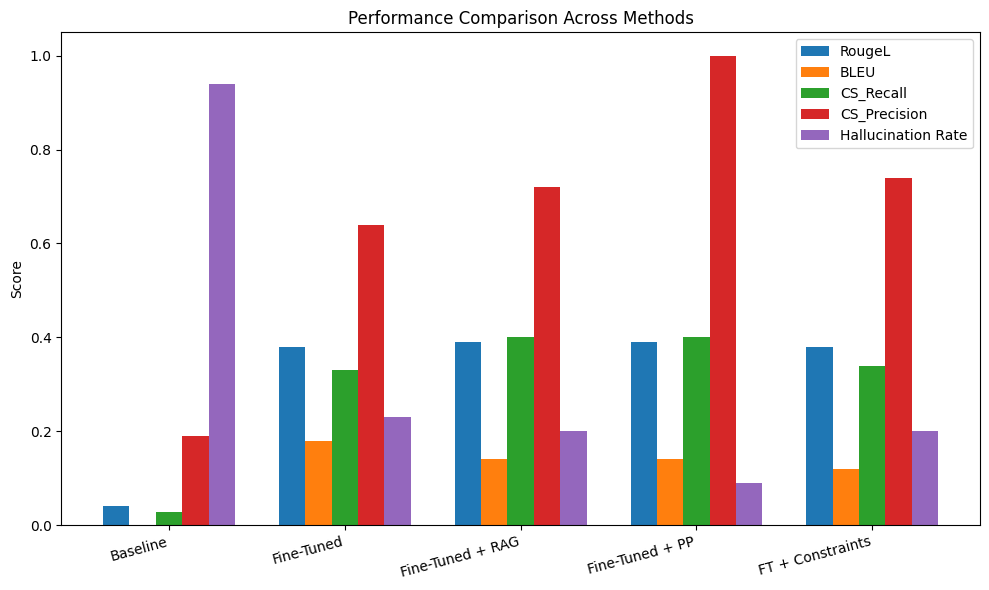

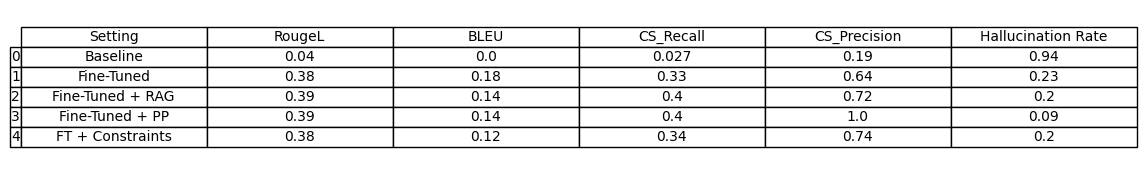

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Data
data = {
    "Setting": [
        "Baseline",
        "Fine-Tuned",
        "Fine-Tuned + RAG",
        "Fine-Tuned + PP",
        "FT + Constraints"
    ],
    "RougeL": [0.04, 0.38, 0.39, 0.39, 0.38],
    "BLEU": [0.0, 0.18, 0.14, 0.14, 0.12],
    "CS_Recall": [0.027, 0.33, 0.4, 0.4, 0.34],
    "CS_Precision": [0.19, 0.64, 0.72, 1.0, 0.74],
    "Hallucination Rate": [0.94, 0.23, 0.2, 0.09, 0.2]
}

df = pd.DataFrame(data)
metrics = ["RougeL", "BLEU", "CS_Recall", "CS_Precision", "Hallucination Rate"]

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.15
positions = range(len(df["Setting"]))

# Plot bars for each metric
for i, metric in enumerate(metrics):
    ax.bar(
        [p + i * bar_width for p in positions],
        df[metric],
        width=bar_width,
        label=metric
    )

# Format plot
ax.set_xticks([p + 2 * bar_width for p in positions])
ax.set_xticklabels(df["Setting"], rotation=15, ha="right")
ax.set_ylabel("Score")
ax.set_title("Performance Comparison Across Methods")
ax.legend()

plt.tight_layout()
plt.show()

# Display the table separately
import matplotlib.pyplot as plt
from pandas.plotting import table

fig, ax = plt.subplots(figsize=(10, 2))
ax.axis("off")
tbl = table(ax, df.round(3), loc="center", cellLoc="center", colWidths=[0.2]*len(df.columns))
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.2)

plt.show()
